# CancerSEEK -- New Sequencing - Feature Engineering as in study - SFS


This notebook will train  **Logistic regression**, **KNN**, **SVC**, **Random Forest**, **Gradient Boosting**, **XGBoost**, **LGBM**, **CatBoost** and **Regularized Greedy Forest (RGF)** on **Winsorized Healthy** or **Scaled Winsorized Healthy** data, depending on whether the model needs data to be scaled. The objective is to see which of the pre-processing steps works best for each of the algorithms on this dataset. Sensitivity and Specificity will be used as evaluation metrics. 

**Feature Engineering**, will be done as mentioned in [this](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5617273/) publication where a combination of mutations and proteins will be evaluated. The same combinations were likely used in the CancerSEEK study. The combinations are as follow:

- `CEA` + `HGF` + `OPN`
- `Mutations` + `CA19-9`
- `Mutations` + `CEA` + `HGF` + `OPN`
- `CA19-9` + `CEA` + `HGF` + `OPN`
- And a combination of them all, referred to as `Combination Assay`, constituting of `Mutations` + `CA19-9` + `CEA` + `HGF` + `OPN`


Based on earlier experiemnts in notebooks "*CancerSEEK -- New Sequencing - Testing Pre-processing steps (1)*" and "*CancerSEEK -- New Sequencing - Testing Pre-processing steps (2) - more Models*" the overall best and most consistent pre-processing step turned out to be the approach used in the publication; **Winsorizing the healthy samples**. As some of the models (parametric models) demonstrated better performance on scaled data the input data will thus be scaled to accomodate such requirements. 



The "best" set of features will be selected using **Sequential Forward Selection** from the [mlxtend](https://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/#example-8-sequential-feature-selection-and-gridsearch) library. 



## Cancer detection through the multi-analyte blood test CancerSEEK


Referring to [this original](https://science.sciencemag.org/content/359/6378/926.long) publication and [this, with a new sequencing](https://www.pnas.org/content/early/2020/02/18/1910041117) method applied.


In [88]:
import pandas as pd
import numpy as np
import warnings
import pickle
import time
import itertools
from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

#from mlxtend.plotting import plot_decision_regions
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from sklearn.metrics import recall_score, precision_score, make_scorer, confusion_matrix
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import power_transform, StandardScaler
from sklearn import tree, ensemble
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
import xgboost as xgb
from catboost import CatBoostClassifier
from rgf.sklearn import RGFClassifier
import lightgbm as lgb

from scipy.stats.mstats import winsorize
from scipy.stats import boxcox, jarque_bera, normaltest

%matplotlib inline
sns.set(style="whitegrid")

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)

## Data Exploration and Cleaning

In [2]:
# Load the dataset
data = pd.read_excel('Dataset S7.xlsx', skiprows=1)

In [3]:
print(data.shape)
print("Unique patient IDs: {}".format(len(data['Patient ID #'].unique())))
data.head()

(1695, 14)
Unique patient IDs: 1695


,Patient ID #,Sample ID #,Tumor type,AJCC Stage,Aneuploidy,Mutation,AFP (pg/ml),CA-125 (U/ml),CA19-9 (U/ml),CEA (pg/ml),HGF (pg/ml),OPN (pg/ml),Prolactin (pg/ml),TIMP-1 (pg/ml)
0,CRC 455,CRC 455 PLS 1,Colorectum,I,0.176106,2.962820,1583.450,5.090,16.452,540.07,377.26,56516.58,11606.60,56428.71
1,CRC 456,CRC 456 PLS 1,Colorectum,I,0.621596,2.445405,715.308,7.270,40.910,5902.43,659.68,61001.39,14374.99,73940.49
2,CRC 457,CRC 457 PLS 1,Colorectum,II,0.591770,1.215758,4365.530,4.854,16.452,973.75,329.07,88896.24,38375.00,22797.28
3,CRC 458,CRC 458 PLS 1,Colorectum,II,0.562455,1.640793,715.308,5.390,16.452,2027.53,266.66,42549.61,12072.51,20441.19
4,CRC 459,CRC 459 PLS 1,Colorectum,II,0.052949,1.325771,801.300,4.854,16.452,614.49,370.88,24274.11,23718.17,56288.51


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1695 entries, 0 to 1694
Data columns (total 14 columns):
Patient ID #         1695 non-null object
Sample ID #          1695 non-null object
Tumor type           1695 non-null object
AJCC Stage           883 non-null object
Aneuploidy           1131 non-null float64
Mutation             1630 non-null float64
AFP (pg/ml)          1695 non-null float64
CA-125 (U/ml)        1695 non-null float64
CA19-9 (U/ml)        1695 non-null float64
CEA (pg/ml)          1695 non-null float64
HGF (pg/ml)          1695 non-null float64
OPN (pg/ml)          1695 non-null float64
Prolactin (pg/ml)    1695 non-null float64
TIMP-1 (pg/ml)       1695 non-null float64
dtypes: float64(10), object(4)
memory usage: 185.5+ KB


This time there seem to be adequate number of Patient IDs and in accordance to what's communicated in the publication; 1695. We can also see that there are 883 patients with cancer as displayed by the non-null values in column `AJCC Stage`.

Furthermore, we can drop columns that are not needed, such as `Sample ID #` and `Patient ID #`, or are too related to the target variable, as `AJCC Stage`, as well as replacing NaN values with 0 in the columns `Aneuploidy` and `Mutation`.

In [5]:
# Delete columns Sample ID and AJCC Stage and Patient ID
if "Sample ID #" in data.columns:
    data.drop(["Sample ID #", "AJCC Stage", "Patient ID #"], axis=1, inplace=True)


# Replace NaN values with 0
data.loc[:, "Aneuploidy"].fillna(0, inplace=True)
data.loc[:, "Mutation"].fillna(0, inplace=True)


### Change column "Tumor type" to ordinal categorical ###
if 'Colorectum' in data['Tumor type'].unique():
    data.replace({'Tumor type': {'Colorectum': 1, 
                                 'Lung': 2,
                                 'Breast': 3,
                                 'Pancreas': 4,
                                 'Ovary': 5,
                                 'Esophagus': 6,
                                 'Liver': 7,
                                 'Stomach': 8,
                                 'Normal': 9}}, inplace=True)

In [6]:
#data[data["Aneuploidy"] == 0]
data.describe([.25, .5, .75, .90])

,Tumor type,Aneuploidy,Mutation,AFP (pg/ml),CA-125 (U/ml),CA19-9 (U/ml),CEA (pg/ml),HGF (pg/ml),OPN (pg/ml),Prolactin (pg/ml),TIMP-1 (pg/ml)
count,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.00000,1695.000000
mean,5.854867,0.253563,3.803496,6643.809436,21.624168,53.101788,4346.874935,318.400186,55464.116428,30426.35720,69727.203068
std,3.405522,0.360617,18.102827,50066.948263,154.670070,419.604271,23874.785867,481.549152,47854.633728,50014.47526,47238.133181
min,1.000000,0.000000,0.000000,706.158000,4.608000,14.214000,426.438000,158.334000,3218.166000,806.28000,976.550000
25%,2.000000,0.000000,0.671253,822.144000,4.884000,16.320000,603.730000,163.995000,25575.805000,8412.78000,41127.780000
50%,8.000000,0.028435,0.937788,929.640000,4.980000,16.482000,1035.150000,183.180000,40388.190000,13521.30000,58986.980000
75%,9.000000,0.473461,1.285354,1845.855000,6.270000,18.380000,1886.430000,290.090000,67337.810000,26075.09000,82923.445000
90%,9.000000,0.925135,3.565479,3836.556000,12.950000,38.104000,3700.642000,508.470000,117451.458000,73188.27000,118113.364000
max,9.000000,0.999718,333.234911,600608.892000,3329.740000,12491.472000,337245.426000,11432.980000,406443.400000,608432.38200,569512.690000


In [7]:
original_columns = data.columns
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1695 entries, 0 to 1694
Data columns (total 11 columns):
Tumor type           1695 non-null int64
Aneuploidy           1695 non-null float64
Mutation             1695 non-null float64
AFP (pg/ml)          1695 non-null float64
CA-125 (U/ml)        1695 non-null float64
CA19-9 (U/ml)        1695 non-null float64
CEA (pg/ml)          1695 non-null float64
HGF (pg/ml)          1695 non-null float64
OPN (pg/ml)          1695 non-null float64
Prolactin (pg/ml)    1695 non-null float64
TIMP-1 (pg/ml)       1695 non-null float64
dtypes: float64(10), int64(1)
memory usage: 145.8 KB


,Tumor type,Aneuploidy,Mutation,AFP (pg/ml),CA-125 (U/ml),CA19-9 (U/ml),CEA (pg/ml),HGF (pg/ml),OPN (pg/ml),Prolactin (pg/ml),TIMP-1 (pg/ml)
0,1,0.176106,2.962820,1583.450,5.090,16.452,540.07,377.26,56516.58,11606.60,56428.71
1,1,0.621596,2.445405,715.308,7.270,40.910,5902.43,659.68,61001.39,14374.99,73940.49
2,1,0.591770,1.215758,4365.530,4.854,16.452,973.75,329.07,88896.24,38375.00,22797.28
3,1,0.562455,1.640793,715.308,5.390,16.452,2027.53,266.66,42549.61,12072.51,20441.19
4,1,0.052949,1.325771,801.300,4.854,16.452,614.49,370.88,24274.11,23718.17,56288.51


# Feature Engineering

In [9]:
# Engineer the features according to the publication
data["CEA+HGF+OPN"] = data["CEA (pg/ml)"] + data["HGF (pg/ml)"] + data["OPN (pg/ml)"]
data["Mutation + CA19-9"] = data["Mutation"] + data["CA19-9 (U/ml)"]
data["Mutation + CEA + HGF + OPN"] = data["Mutation"] + data["CEA+HGF+OPN"]
data["CA19-9 + CEA + HGF + OPN"] = data["CA19-9 (U/ml)"] + data["CEA+HGF+OPN"]
data["Combination assay"] = data["Mutation + CEA + HGF + OPN"] + data["CA19-9 (U/ml)"]

In [10]:
data.head()

,Tumor type,Aneuploidy,Mutation,AFP (pg/ml),CA-125 (U/ml),CA19-9 (U/ml),CEA (pg/ml),HGF (pg/ml),OPN (pg/ml),Prolactin (pg/ml),TIMP-1 (pg/ml),CEA+HGF+OPN,Mutation + CA19-9,Mutation + CEA + HGF + OPN,CA19-9 + CEA + HGF + OPN,Combination assay
0,1,0.176106,2.962820,1583.450,5.090,16.452,540.07,377.26,56516.58,11606.60,56428.71,57433.91,19.414820,57436.872820,57450.362,57453.324820
1,1,0.621596,2.445405,715.308,7.270,40.910,5902.43,659.68,61001.39,14374.99,73940.49,67563.50,43.355405,67565.945405,67604.410,67606.855405
2,1,0.591770,1.215758,4365.530,4.854,16.452,973.75,329.07,88896.24,38375.00,22797.28,90199.06,17.667758,90200.275758,90215.512,90216.727758
3,1,0.562455,1.640793,715.308,5.390,16.452,2027.53,266.66,42549.61,12072.51,20441.19,44843.80,18.092793,44845.440793,44860.252,44861.892793
4,1,0.052949,1.325771,801.300,4.854,16.452,614.49,370.88,24274.11,23718.17,56288.51,25259.48,17.777771,25260.805771,25275.932,25277.257771


# Visualise the data

Visualise the data using Boxplots, histograms and various correlation plots to get a better understanding of it. Do this for Normal (or *Non-transformed*), *Winsorized*, *Log transformed*, *BoxCox transformed* and *Yeo-Johnson transformed* data. 

Start by plotting the total count of each Tumor type, including healthy Normal. This plot is common for all pre-processed data. 

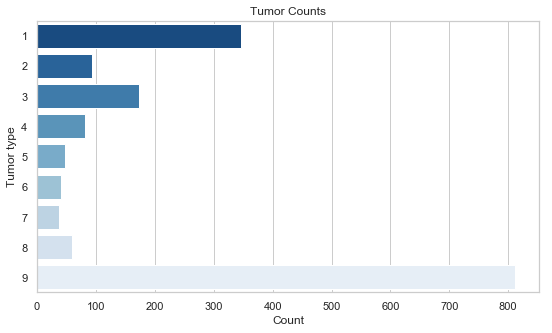

In [11]:
plt.figure(figsize=(9,5))
sns.countplot(y="Tumor type", data=data.sort_values("Tumor type"), palette="Blues_r")
plt.title("Tumor Counts")
plt.xlabel("Count");

## Non-transformed data

Plot the target variable `Tumor type` relative the variables using boxplots while histograms aids the understanding of each variable's distribution. 

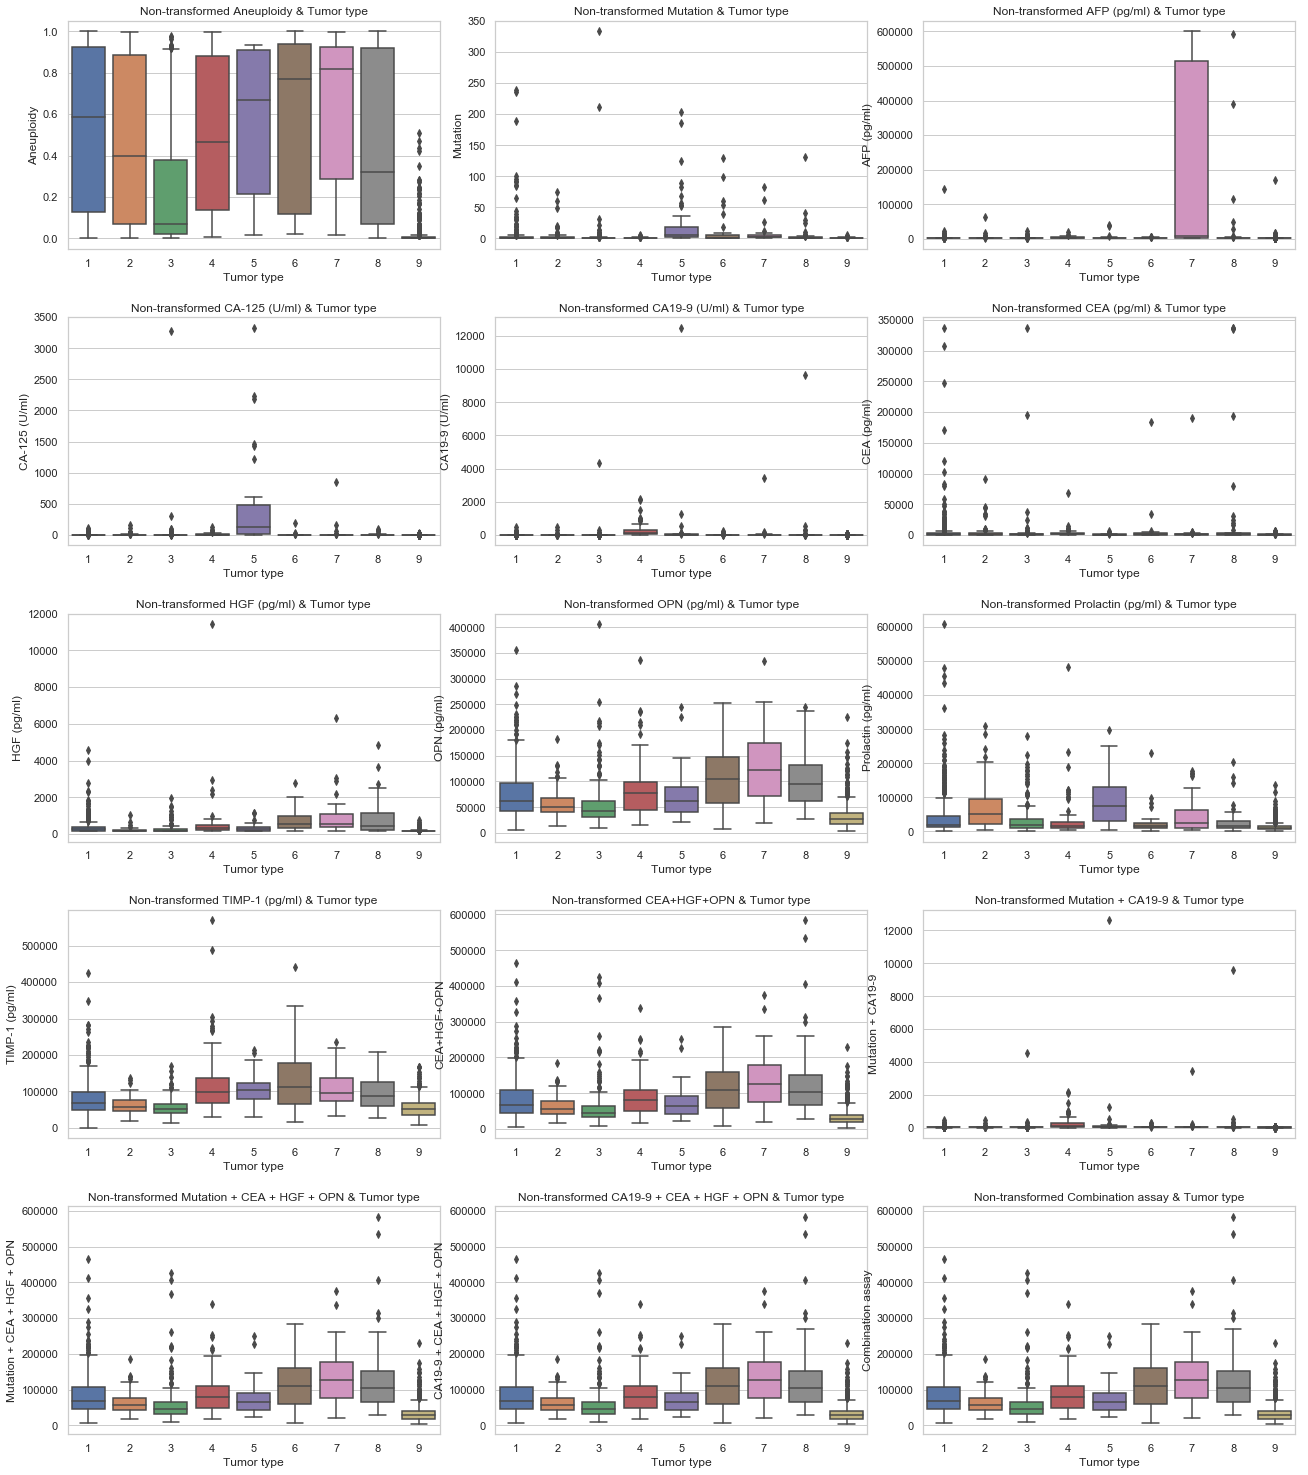

In [12]:
plt.figure(figsize=(22,26))
for count, column in enumerate(data.columns[1:], 1):
    plt.subplot(5, 3, count)
    sns.boxplot(x="Tumor type", y=column, data=data)
    plt.title("Non-transformed " + column + " & Tumor type")
    
plt.subplots_adjust(hspace=0.3, wspace=0.15)

Following histograms shows the distribution for each variable as well as t-statistic and p-values from a Normal test. None of the variables are normally distributed. 

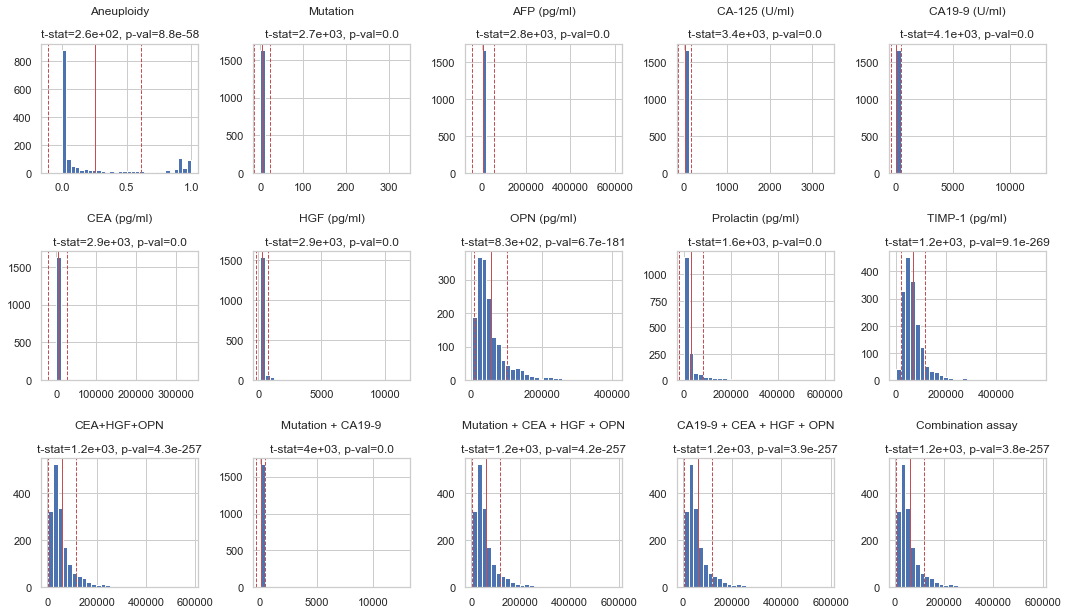

In [13]:
plt.figure(figsize=(18,10))

# Plot histograms of the Non-transformed data
for count, column in enumerate(data.columns[1:], 1):
    to_plot = data[column]
    plt.subplot(3, 5, count)
    
    # Plot a histogram
    plt.hist(to_plot, bins=30)
    
    # Add a vertical line at the mean.
    plt.axvline(to_plot.mean(), color='r', linestyle='solid', linewidth=1)

    # Add a vertical line at one standard deviation above the mean.
    plt.axvline(to_plot.mean() + to_plot.std(), color='r', linestyle='dashed', linewidth=1)

    # Add a vertical line at one standard deviation below the mean.
    plt.axvline(to_plot.mean()-to_plot.std(), color='r', linestyle='dashed', linewidth=1) 

    # Calculate statistics for normality
    k2, p = normaltest(data.loc[:, column])
    plt.title(column + "\n\nt-stat={0:.2}, p-val={1:.2}".format(k2, p))

plt.subplots_adjust(hspace=0.6, wspace=0.35)

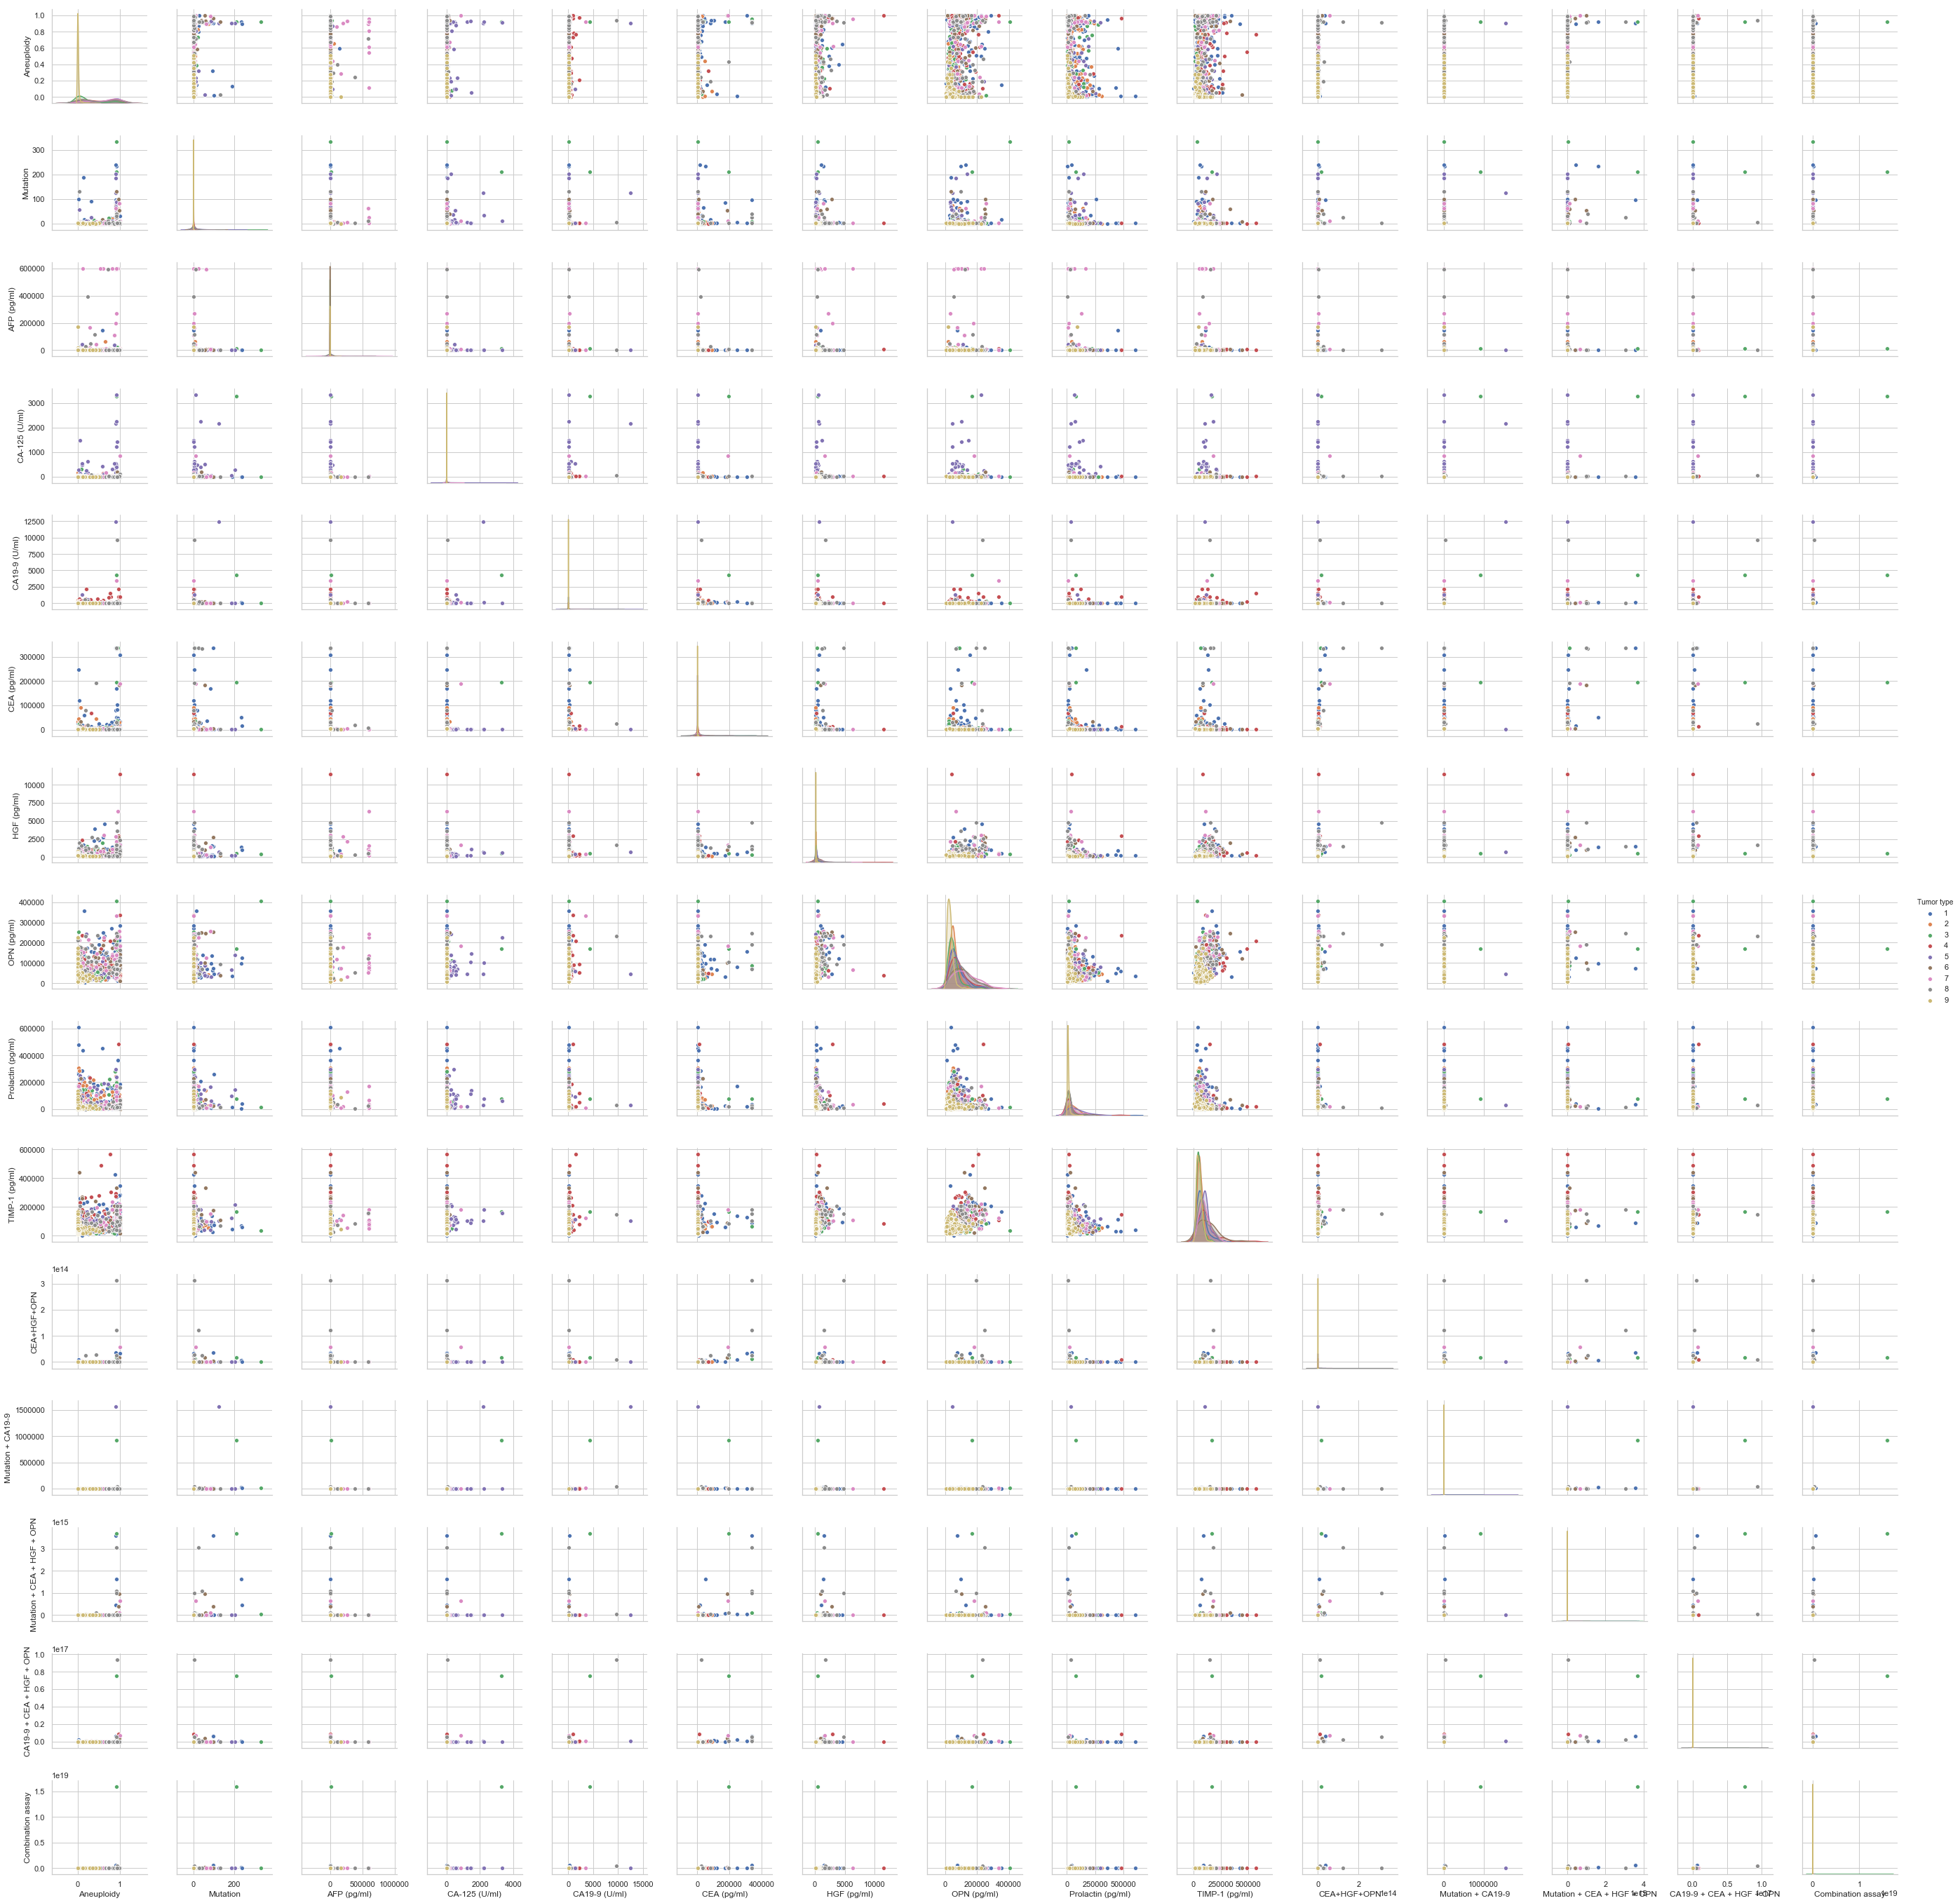

In [501]:
sns.pairplot(data, hue="Tumor type");

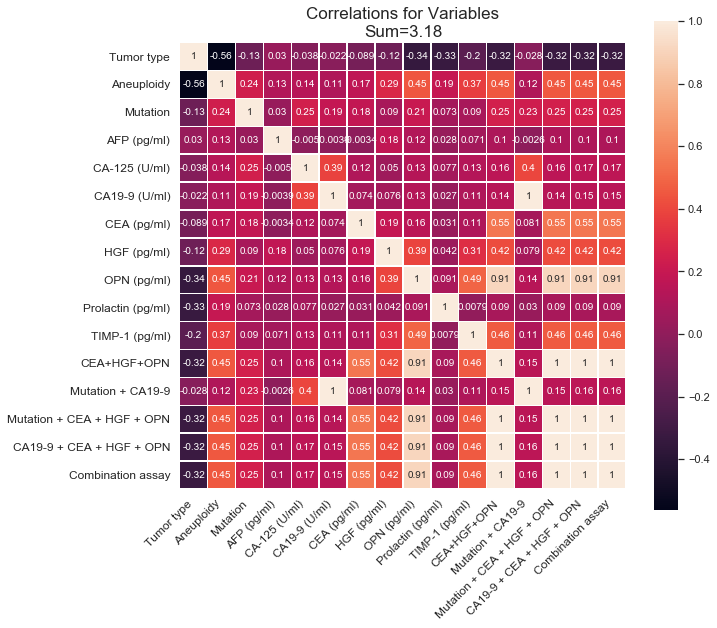

In [14]:
plt.figure(figsize=(10,9))

corr_mat = data.corr()
summ = abs(corr_mat["Tumor type"][1:]).sum()
sns.heatmap(corr_mat, square=True, annot=True, linewidths=.5)
plt.title('Correlations for Variables\nSum={:.3}'.format(summ), size=17)
plt.xticks(size=12, rotation=45, horizontalalignment="right")
plt.yticks(size=12);

Above correlation matrix displays the correlation between each variable with the target variable `Tumor type`. Several features are fairly correlated with the target, such as `Aneuploidy`, `OPN` and `Prolactin` while `Mutation`, `AFP`, `CA-125`, `CA19-9`, `CEA` and `HGF` migth benefit from some feature engineering. 


## Winsorized data - According to the publication, only applied on healthy samples


Start by creating a new dataframe with Winsorized data. It's just a copy of the original data above. Then apply winsorization in the same way as in [the publication](https://www.pnas.org/content/early/2020/02/18/1910041117) on the healthy patients. That is, values above the 90th percentile for **healthy samples** are imputed to the 90th percentile threshold. 

In [15]:
winsorized_healthy = data.copy(deep=True)

In [16]:
# Perform Winsorization
Winz = winsorize(winsorized_healthy.iloc[:, 1:].loc[winsorized_healthy["Tumor type"] == 9], limits=[0, 0.1])
winsorized_healthy.loc[winsorized_healthy["Tumor type"] == 9, winsorized_healthy.columns[1:]] = Winz
del Winz # not needed to store this variable in memory

Plot the `AFP (pg/ml)` column before and after winsorizing using histograms to display the difference. Plot only the distribution of healthy samples. 

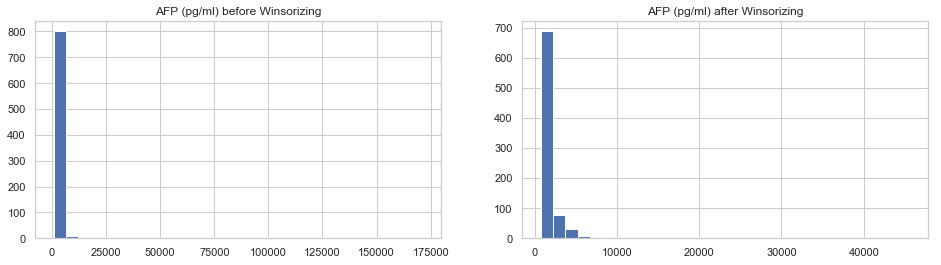

In [17]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.hist(data.loc[data["Tumor type"] == 9, "AFP (pg/ml)"], 30)
plt.title("AFP (pg/ml) before Winsorizing")

plt.subplot(1, 2, 2)
plt.hist(winsorized_healthy.loc[winsorized_healthy["Tumor type"] == 9, "AFP (pg/ml)"], 30)
plt.title("AFP (pg/ml) after Winsorizing");

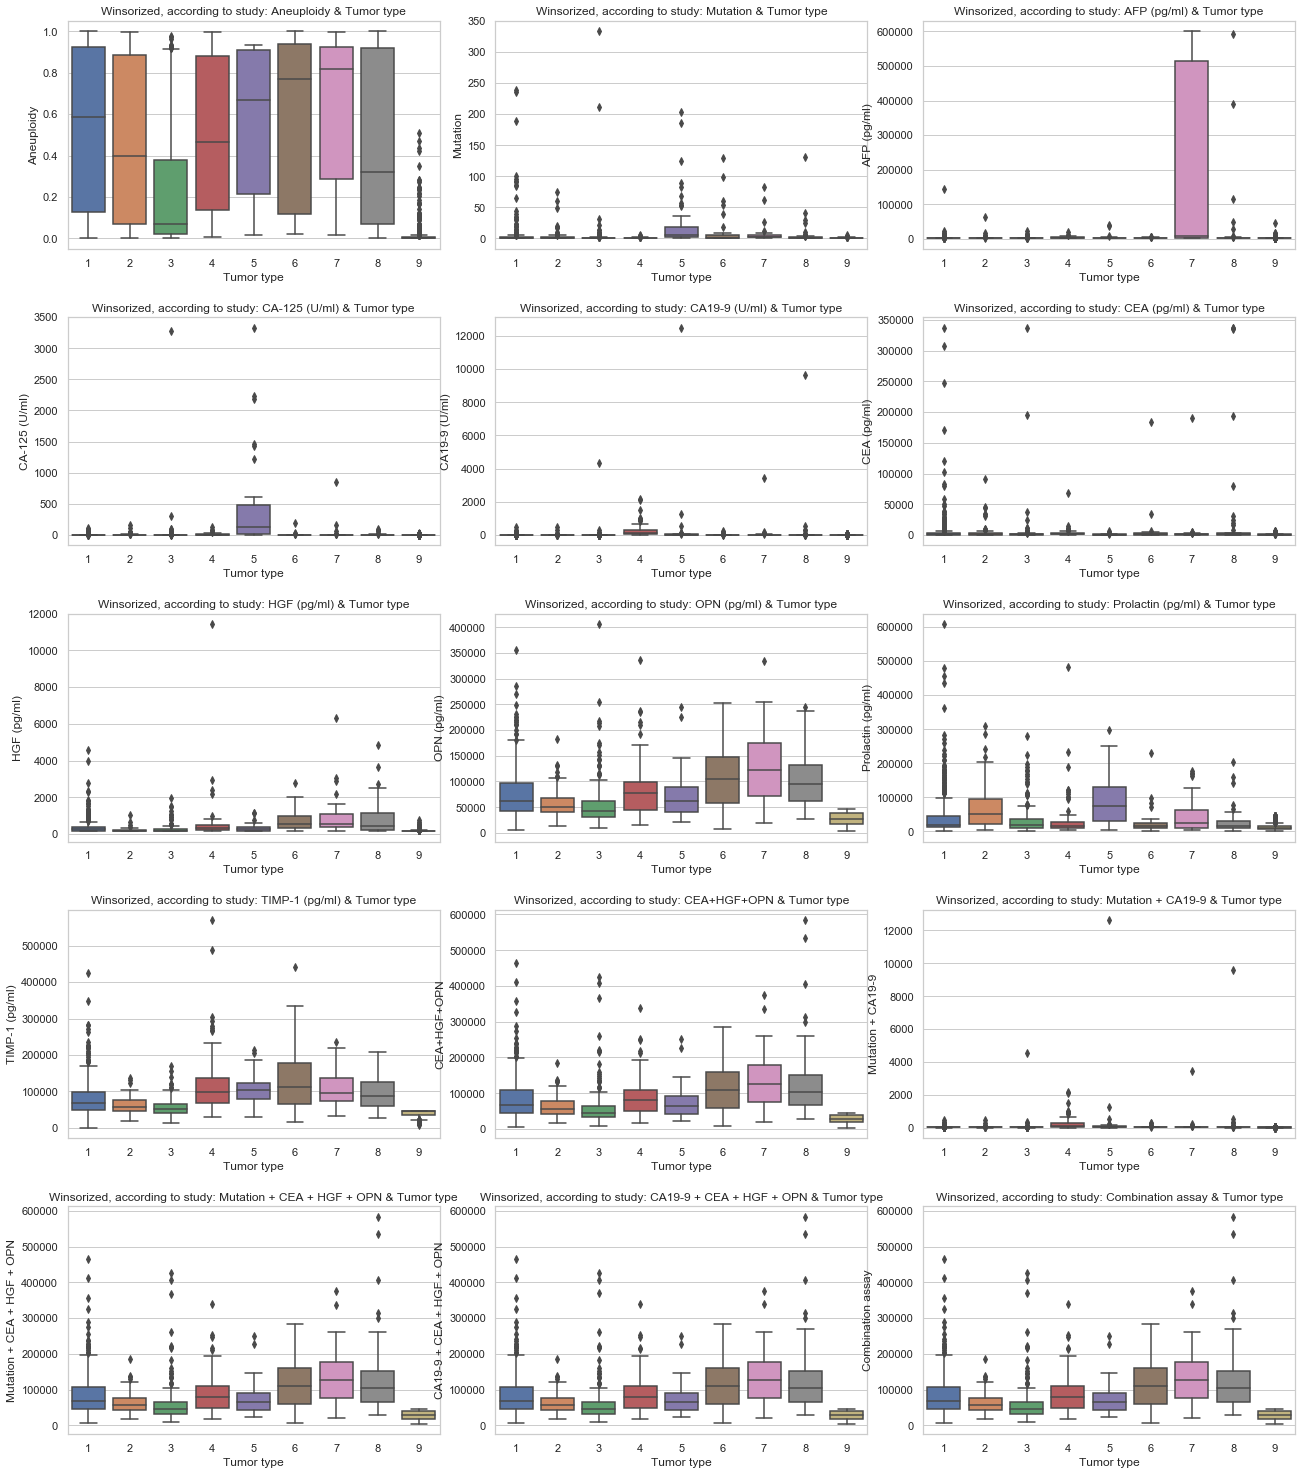

In [18]:
plt.figure(figsize=(22,26))
for count, column in enumerate(winsorized_healthy.columns[1:], 1):
    plt.subplot(5, 3, count)
    sns.boxplot(x="Tumor type", y=column, data=winsorized_healthy)
    plt.title("Winsorized, according to study: " + column + " & Tumor type")
    
plt.subplots_adjust(hspace=0.3, wspace=0.15)

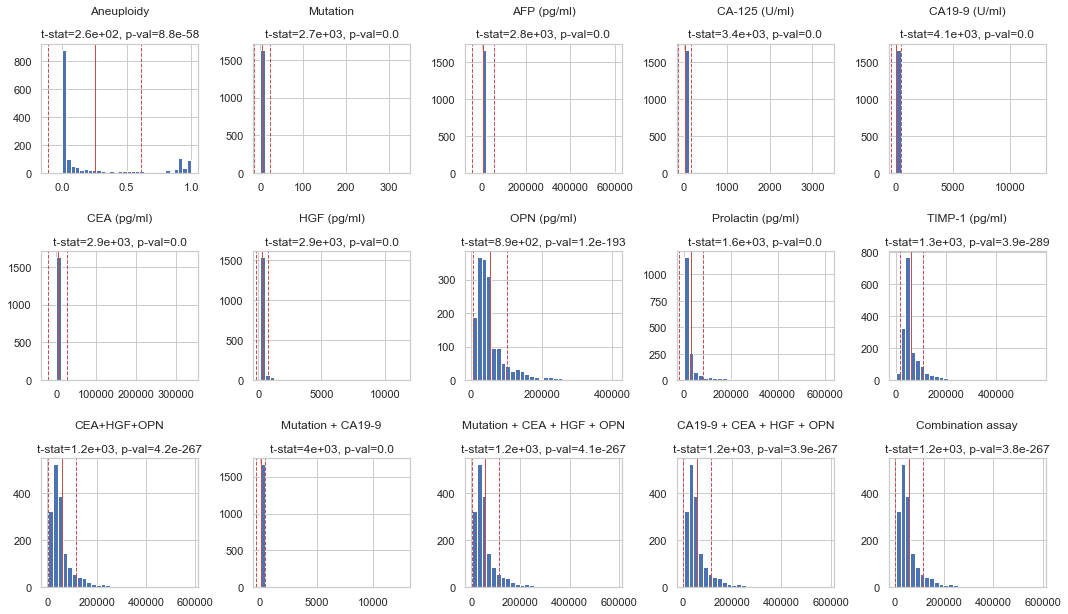

In [19]:
plt.figure(figsize=(18,10))

# Plot histograms of the Winsorized data
for count, column in enumerate(winsorized_healthy.columns[1:], 1):
    to_plot = winsorized_healthy[column]
    plt.subplot(3, 5, count)
    
    # Plot a histogram
    plt.hist(to_plot, bins=30)
    
    # Add a vertical line at the mean.
    plt.axvline(to_plot.mean(), color='r', linestyle='solid', linewidth=1)

    # Add a vertical line at one standard deviation above the mean.
    plt.axvline(to_plot.mean() + to_plot.std(), color='r', linestyle='dashed', linewidth=1)

    # Add a vertical line at one standard deviation below the mean.
    plt.axvline(to_plot.mean()-to_plot.std(), color='r', linestyle='dashed', linewidth=1) 

    # Calculate statistics for normality
    k2, p = normaltest(winsorized_healthy.loc[:, column])
    plt.title(column + "\n\nt-stat={0:.2}, p-val={1:.2}".format(k2, p))

plt.subplots_adjust(hspace=0.6, wspace=0.35)

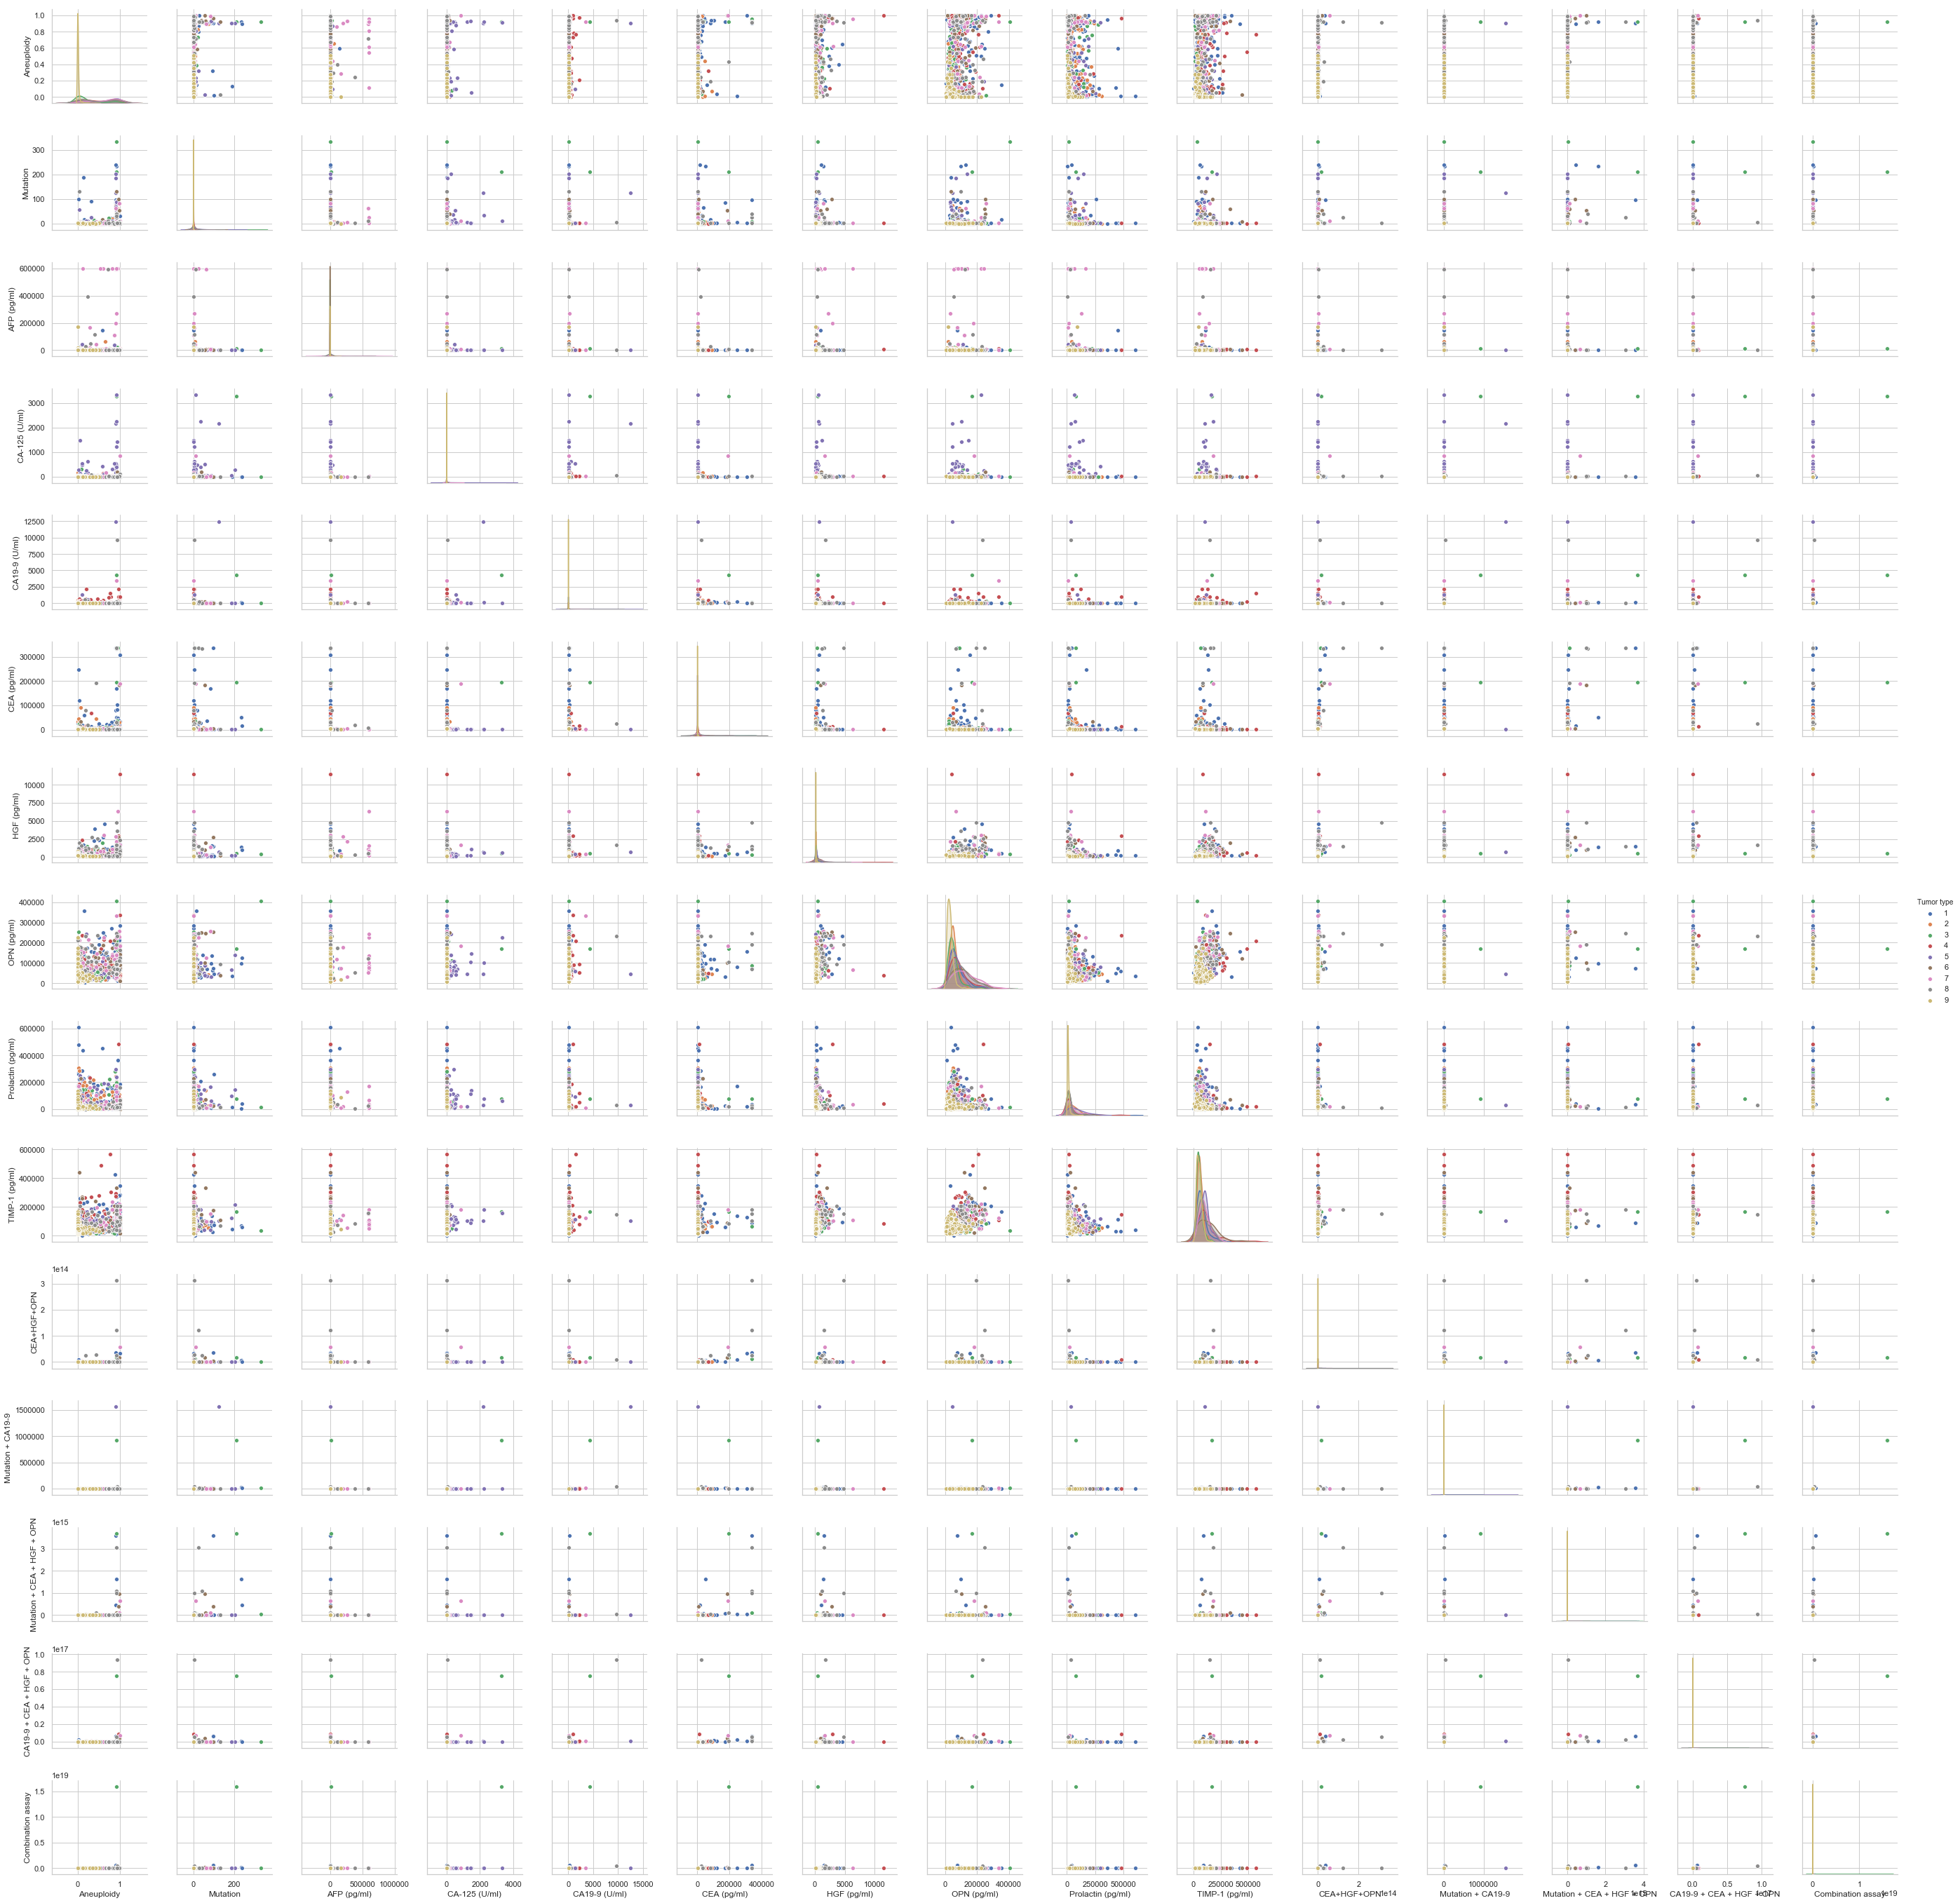

In [508]:
sns.pairplot(winsorized_healthy, hue="Tumor type");

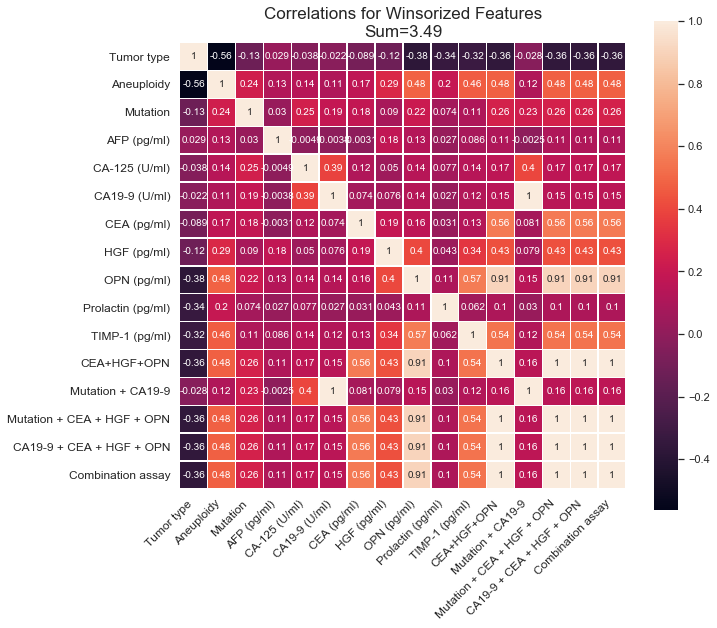

In [20]:
plt.figure(figsize=(10,9))

corr_mat = winsorized_healthy.corr()
summ = abs(corr_mat["Tumor type"][1:]).sum()
sns.heatmap(corr_mat, square=True, annot=True, linewidths=.5)
plt.title('Correlations for Winsorized Features\nSum={:.3}'.format(summ), size=17)
plt.xticks(size=12, rotation=45, horizontalalignment="right")
plt.yticks(size=12);

## Summary of pre-processed data

In [21]:
summary_df = pd.DataFrame({"Non-transformed": data.corr()["Tumor type"],
                           "Winsorized Healthy": winsorized_healthy.corr()["Tumor type"]})

# Add the sum in the last row. Tumor type's correlation with itself is excluded from the sum. 
summs = pd.DataFrame(abs(summary_df.iloc[1:, :].sum(0)), columns=["Total Correlation"]).T
summary_df = pd.concat([summary_df, summs], axis=0)
summary_df

,Non-transformed,Winsorized Healthy
Tumor type,1.000000,1.000000
Aneuploidy,-0.563501,-0.563501
Mutation,-0.125467,-0.125467
AFP (pg/ml),0.030268,0.028987
CA-125 (U/ml),-0.038494,-0.038494
CA19-9 (U/ml),-0.022468,-0.022468
CEA (pg/ml),-0.089327,-0.089327
HGF (pg/ml),-0.120382,-0.120382
OPN (pg/ml),-0.340390,-0.379152
Prolactin (pg/ml),-0.329747,-0.335187


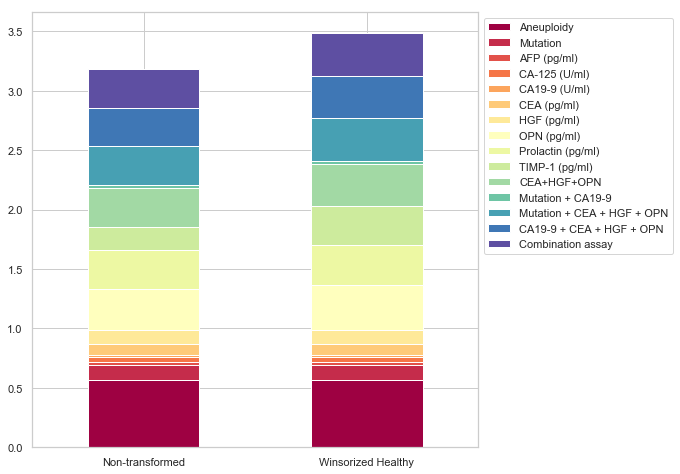

In [22]:
# Plot a summary plot
abs(summary_df.iloc[1:-1, :]).T.plot(kind="bar", stacked=True, figsize=(8, 8), 
                                     rot=0, colormap="Spectral").legend(bbox_to_anchor=(1,1));

# Model Evaluation



**Logistic regression**, **KNN**, **SVC**, **Random Forest**, **Gradient Boosting**, **XGBoost**, **LGBM**, **CatBoost** and **Regularized Greedy Forest (RGF)** models will be trained and evaluated on the data. When a model's requirements necessitates parametric input data, the data will be scaled [-1, 1] with mean = 1 prior to fitting the model.  The evaluation will start with the more simplistic models and with minimal model parameter tuning. 

In [23]:
def print_feature_importance(model, X, n=5):
    """Function to print the top n features model use to base its predictions on. 
       X is the full feature set used to train the model. """
    feature_importance = model.feature_importances_
    feature_df= pd.DataFrame({'feature': X.columns,
                              'importance':feature_importance})
    feature_df.sort_values(by='importance', ascending=False, inplace=True)
    return feature_df.head(n)



def plot_confusion_matrix(testY, predicted, target_names=None, title='Confusion matrix', 
                          cmap=None, normalize=False, figsize=(8,6)):
    """
    Arguments
    ---------
    cm:           true values on the test set
    
    predicted:    predicted values on test set

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    figsize:      Size of figure, specified as (x, y). For example (7, 5)
    

    Citation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html


    Setting Seaborn plotting options
    ---------
    https://seaborn.pydata.org/tutorial/aesthetics.html#overriding-elements-of-the-seaborn-styles
    
    """
    
    cm = confusion_matrix(testY, predicted)
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    sns.set_style("darkgrid", {"axes.grid": False}) # Remove the grid
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=16)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, horizontalalignment="right")
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center", verticalalignment="center",
                     color="black" if cm[i, j] > thresh else "white")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center", verticalalignment="center",
                     color="black" if cm[i, j] > thresh else "white")


    plt.tight_layout()
    plt.ylabel('Predicted label', size=14)
    plt.xlabel('True label', size=14)
    plt.show()



# Specify a list with the various cancers for later use
cancers = ['Colorectum', 'Lung', 'Breast', 'Pancreas', 'Ovary', 
           'Esophagus', 'Liver', 'Stomach', 'Healthy', 'All']
      


def specificity_score(true, predicted, labels=None, pos_label=1, 
                      average='weighted',sample_weight=None, zero_division="warn"):
    """Specificity scorer function for Cross Validation. """
    
    # Create confusion matrix
    conf_matrix = pd.DataFrame(confusion_matrix(true, predicted))
    new_ind = conf_matrix.index.append(pd.Index(["All"]))
    
    # Add a summary column and index
    conf_matrix["All"] = conf_matrix.sum(axis=1)
    indAll = pd.DataFrame(conf_matrix.sum(axis=0)).T
    conf_matrix = pd.concat([conf_matrix, indAll], axis=0)
    conf_matrix.index = new_ind
    
    # Calculate Specificity 
    specificity = conf_matrix.loc[8, 8] / conf_matrix.loc[8, "All"]
    
    return specificity

In [24]:
# Collect the transformed datasets in a dictionary
datasets = {"Winsorized_Healthy": winsorized_healthy}

# Full column names and Shorter alternatives stored in lists
full_name_columns = ["Winsorized_Healthy", "Winsorized_Healthy_scaled"]

shorter_name_columns = ["Wins_Hlthy", "Wins_Hlthy_sca"]

## Logistic Regression


Following several iterations (training takes very long time) and subsequent error messages, scaling is performed using Sklearn's [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) on the datasets that do not have mean ≈ 0. An inversed scaler can then be used to get the orignal dataset. 


>**Standardization** of datasets is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.
>
>In practice we often ignore the shape of the distribution and just transform the data to center it by removing the mean value of each feature, then scale it by dividing non-constant features by their standard deviation.
>
>For instance, many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines or the l1 and l2 regularizers of linear models) assume that all features are centered around zero and have variance in the same order. If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

In [786]:
# Store Cross Validated scores, models and scalers here
cv_scores_LogReg = {}; models_LogReg = {}; data_Scalers_LogReg = {}
metrics_LogReg = {}

# Time it
start = time.time()

# Fit, train and cross validate on all seven datasets
for dataset_name in datasets:

    # Define predictors and outcome. Convert into numpy array
    X = datasets[dataset_name].iloc[:, 1:]
    Y = datasets[dataset_name]["Tumor type"].values
    
    # Store column names
    column_names = datasets[dataset_name].columns[1:]
    
    # Scale data
    scaler_LogReg = StandardScaler()
    X = scaler_LogReg.fit_transform(X)

    # Store Scaler
    dataset_name = dataset_name + "_scaled"
    data_Scalers_LogReg[dataset_name] = scaler_LogReg
    
    
    # Split into train and test sets. Use 20% for testing
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
    
    # Specify column names for train data
    trainX = pd.DataFrame(trainX, columns=column_names)

    # Create a Logistic Regression model
    logReg = LogisticRegression(max_iter=2000)
    
    
    print(f'cv=5 Sequential Forward Selection & cv=5 Grid Search on {dataset_name}')
    
    # Find the best set of features using Sequential Forward Selection
    sfs_logReg = SFS(estimator=logReg, 
                     k_features=(5, 15),
                     forward=True, 
                     floating=False, 
                     scoring='accuracy',
                     cv=5)    #fixed_features=tuple(range(8)),
    
    # Create a Pipeline
    pipeline_logReg = Pipeline([('sfs_logReg', sfs_logReg), 
                                ('logReg', logReg)])

    # Set parameters for Grid Search
    param_grid = {'logReg__C': [5, 10, 15]}
    
    # Initiate Cross Validated Grid Search to get the best model
    clf_logReg = GridSearchCV(pipeline_logReg, 
                              param_grid,
                              verbose=3, 
                              n_jobs=3,
                              cv=5)
    
    clf_logReg.fit(trainX, trainY)

    
    # Store the best model
    models_LogReg[dataset_name] = clf_logReg.best_estimator_["logReg"]
    
    # Store all metrics from the Grid Search
    metrics_LogReg[dataset_name] = clf_logReg
     
    
    
print("\nDone!")

# Print total time
end = time.time()
tt = end-start
print("\nTotal time: {0:0.0f} min and {1:0.0f}s. ".format((tt-tt%60)/60, tt%60)) 

cv=5 Sequential Forward Selection & cv=5 Grid Search on Winsorized_Healthy_scaled
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:  4.0min finished



Done!

Total time: 4 min and 39s. 


Number of Features: 12
Feature indices:    (0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12)


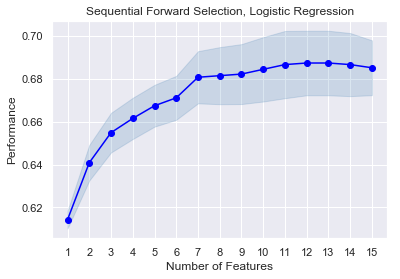

In [792]:
# Get the "best" features after SFS
best_sfs = clf_logReg.best_estimator_["sfs_logReg"]

# Print performance vs number of features
fig = plot_sfs(best_sfs.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection, Logistic Regression')
plt.grid()

print("Number of Features: {}".format(len(best_sfs.k_feature_idx_)))
print("Feature indices:    {}".format(best_sfs.k_feature_idx_))

In [793]:
# Define predictors and outcome. Convert into numpy array
X = datasets["Winsorized_Healthy"].iloc[:, 1:]
Y = datasets["Winsorized_Healthy"]["Tumor type"].values

# Transform X using corresponding scaler
X = data_Scalers_LogReg["Winsorized_Healthy_scaled"].fit_transform(X)

# Select the "best" features
X = X[:, best_sfs.k_feature_idx_]

# Get the best estimator
best_estimator = clf_logReg.best_estimator_["logReg"]


# Cross validate the model with 10 folds on Specificity, Sensitivity (Recall) and Accuracy.
LR_crossV_score = cross_validate(best_estimator, X, Y, cv=10, 
                              scoring={'spec_macro': make_scorer(specificity_score, average='weighted'),
                                       'rec_macro' : make_scorer(recall_score, average='weighted'),
                                       'acc'       : 'accuracy'}, 
                              n_jobs=3, return_train_score=True, verbose=3)

# Store cv results
cv_scores_LogReg[dataset_name] = LR_crossV_score

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.4s finished


In [794]:
# Create a summary over the Cross Validation scores. 
cv_scores_df_LR = pd.DataFrame(columns=["Winsorized_Healthy_scaled"], 
                               index=["Specificity", "Sensitivity", "Accuracy"])

for dataset_name in cv_scores_df_LR.columns:
    specificity = round(np.median(cv_scores_LogReg[dataset_name]["test_spec_macro"]), 4)
    sensitivity = round(np.median(cv_scores_LogReg[dataset_name]["test_rec_macro"]), 4)
    accuracy = round(np.median(cv_scores_LogReg[dataset_name]["test_acc"]), 4)
    cv_scores_df_LR[dataset_name] = [specificity, sensitivity, accuracy]
    
cv_scores_df_LR

,Winsorized_Healthy_scaled
Specificity,0.9877
Sensitivity,0.7041
Accuracy,0.7041


In [795]:
# Plot summary statistics of CV scores
#cv_scores_df_LR.plot(kind="bar", figsize=(6, 7), rot=0, grid=True, 
#                     title="Summary plot for CV scores for Logistic Regression").legend(bbox_to_anchor=(1,1));

Best performing model:
 LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


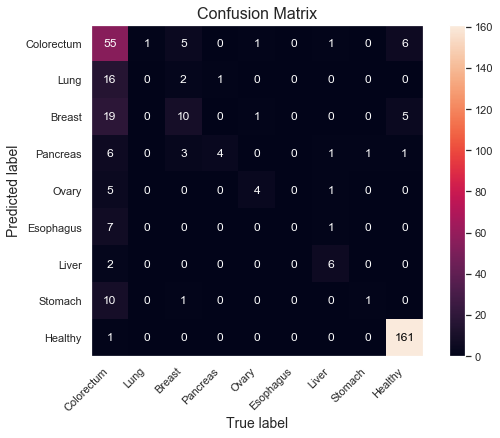

In [796]:
# Print best performing model parameters
best_model = models_LogReg["Winsorized_Healthy_scaled"]
print("Best performing model:\n", best_model)

# Split into train and test sets, same as during training
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Make predictions on above set and plot Confusion Matrix
plot_confusion_matrix(testY, best_model.predict(testX), target_names=[i for i in cancers[:9]], 
                      title = 'Confusion Matrix')

Using Sequential Forward Selection on the 15 features yields worse results for Logistic Regression than in the original feature set. This is a big disappointment.

## K-Nearest Neighbors (KNN)

Input data needs to be scaled for KNN, see documentation and previous experiments (*CancerSEEK -- New Sequencing - Testing Pre-processing steps (1) - StratifiedKFold*). 


From the [documentation](https://scikit-learn.org/stable/modules/neighbors.html#neighbors):

The principle behind nearest neighbor methods is to find a predefined number of training samples closest in distance to the new point, and predict the label from these. The number of samples can be a user-defined constant (k-nearest neighbor learning), or vary based on the local density of points (radius-based neighbor learning). The distance can, in general, be any metric measure: standard Euclidean distance is the most common choice. Neighbors-based methods are known as non-generalizing machine learning methods, since they simply “remember” all of its training data (possibly transformed into a fast indexing structure such as a Ball Tree or KD Tree).

Despite its simplicity, nearest neighbors has been successful in a large number of classification and regression problems, including handwritten digits and satellite image scenes. Being a **non-parametric method**, it is often successful in classification situations where the decision boundary is very irregular.


Great answer on Euclidean Distance and High Dimensions [here](https://stats.stackexchange.com/questions/99171/why-is-euclidean-distance-not-a-good-metric-in-high-dimensions).

In [797]:
# Store Cross Validated scores, models and scalers here
cv_scores_KNN = {}; models_KNN = {}; data_Scalers_KNN = {}; metrics_KNN = {}

# Time it
start = time.time()

# Fit, train and cross validate on all seven datasets
for dataset_name in datasets:

    # Define predictors and outcome. Convert into numpy array
    X = datasets[dataset_name].iloc[:, 1:]
    Y = datasets[dataset_name]["Tumor type"].values
    
    # Scale data
    scaler_KNN = StandardScaler()
    X = scaler_KNN.fit_transform(X)

    # Store Scaler
    dataset_name = dataset_name + "_scaled"
    data_Scalers_KNN[dataset_name] = scaler_KNN
    
    # Split into train and test sets. Use 20% for testing
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
    
    # Create KNN for classification
    knn = KNeighborsClassifier()
    
    print(f'   Recursive Feature Elimination cv=5 & Grid Search cv=5 on {dataset_name}')
    
    # Find the best set of features using Sequential Forward Selection
    sfs_KNN = SFS(estimator=knn, 
                     k_features=(5, 15),
                     forward=True, 
                     floating=False, 
                     scoring='accuracy',
                     cv=5)
    
    # Create a Pipeline
    pipeline_KNN = Pipeline([('sfs_KNN', sfs_KNN), 
                             ('knn', knn)])

    # Set parameters for Grid Search
    param_grid = {'knn__n_neighbors': [3, 4, 5, 6,],
                  'knn__leaf_size':   [10, 20, 30],
                  'knn__p':           [1, 2]}
    
    # Initiate Cross Validated Grid Search to get the best model
    clf_KNN = GridSearchCV(pipeline_KNN, 
                           param_grid,
                           verbose=3, 
                           n_jobs=3,
                           cv=5)
    
    clf_KNN.fit(trainX, trainY)
    
    # Store the best model
    models_KNN[dataset_name] = clf_KNN.best_estimator_["knn"]
    
    # Store all metrics from the Grid Search
    metrics_KNN[dataset_name] = clf_KNN
    
    
    
print("\nDone!")

# Print total time
end = time.time()
tt = end-start
print("\nTotal time: {0:0.0f} min and {1:0.0f}s. ".format((tt-tt%60)/60, tt%60)) 

   Recursive Feature Elimination cv=5 & Grid Search cv=5 on Winsorized_Healthy_scaled
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  1.5min
[Parallel(n_jobs=3)]: Done 120 out of 120 | elapsed:  6.2min finished



Done!

Total time: 6 min and 20s. 


Number of Features: 12
Feature indices:    (0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12)


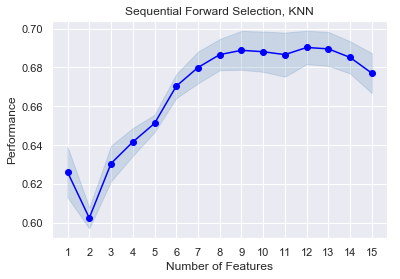

In [798]:
# Get the "best" features after SFS
best_sfs = clf_KNN.best_estimator_["sfs_KNN"]

# Print performance vs number of features
fig = plot_sfs(best_sfs.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection, KNN')
plt.grid()

print("Number of Features: {}".format(len(best_sfs.k_feature_idx_)))
print("Feature indices:    {}".format(best_sfs.k_feature_idx_))

In [799]:
# Define predictors and outcome. Convert into numpy array
X = datasets["Winsorized_Healthy"].iloc[:, 1:]
Y = datasets["Winsorized_Healthy"]["Tumor type"].values

# Transform X using corresponding scaler
X = data_Scalers_KNN["Winsorized_Healthy_scaled"].fit_transform(X)

# Select the "best" features
X = X[:, best_sfs.k_feature_idx_]

# Get the best estimator
best_estimator = clf_KNN.best_estimator_["knn"]


# Cross validate the model with 10 folds on Specificity, Sensitivity (Recall) and Accuracy.
KNN_crossV_score = cross_validate(best_estimator, X, Y, cv=10, 
                              scoring={'spec_macro': make_scorer(specificity_score, average='weighted'),
                                       'rec_macro' : make_scorer(recall_score, average='weighted'),
                                       'acc'       : 'accuracy'}, 
                              n_jobs=3, return_train_score=True, verbose=3)

# Store cv results
cv_scores_KNN[dataset_name] = KNN_crossV_score

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    6.1s finished


In [800]:
# Create a summary over the Cross Validation scores. 
cv_scores_df_KNN = pd.DataFrame(columns=["Winsorized_Healthy_scaled"], 
                               index=["Specificity", "Sensitivity", "Accuracy"])

for dataset_name in cv_scores_df_KNN.columns:
    specificity = round(np.median(cv_scores_KNN[dataset_name]["test_spec_macro"]), 4)
    sensitivity = round(np.median(cv_scores_KNN[dataset_name]["test_rec_macro"]), 4)
    accuracy = round(np.median(cv_scores_KNN[dataset_name]["test_acc"]), 4)
    cv_scores_df_KNN[dataset_name] = [specificity, sensitivity, accuracy]
    
cv_scores_df_KNN

,Winsorized_Healthy_scaled
Specificity,0.9938
Sensitivity,0.6765
Accuracy,0.6765


Best performing model:
 KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')


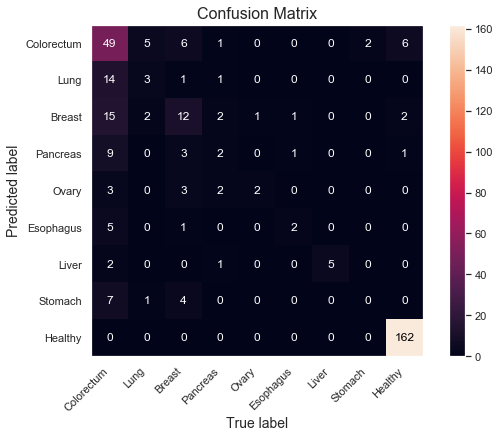

In [801]:
# Print best performing model parameters
best_model = models_KNN["Winsorized_Healthy_scaled"]
print("Best performing model:\n", best_model)

# Split into train and test sets, same as during training
_, testX, _, testY = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Make predictions on above set and plot Confusion Matrix
plot_confusion_matrix(testY, best_model.predict(testX), target_names=[i for i in cancers[:9]], 
                      title = 'Confusion Matrix')

Sequential Forward Selection on KNN yields worse results than the orignal 10 features did. 



## Support Vector Classifier (SVC)


[See some tips on practical use here](https://scikit-learn.org/stable/modules/svm.html#tips-on-practical-use).


Support Vector Machine algorithms are not scale invariant, so it is **highly recommended to scale your data**. For example, scale each attribute on the input vector X to [0,1] or [-1,+1], or standardize it to have mean 0 and variance 1. Note that the same scaling must be applied to the test vector to obtain meaningful results. See section Preprocessing data for more details on scaling and normalization.


The advantages of support vector machines [are](https://scikit-learn.org/stable/modules/svm.html#svm-classification):

- Effective in high dimensional spaces.

- Still effective in cases where number of dimensions is greater than the number of samples.

- Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.

- Versatile: different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.

The disadvantages of support vector machines include:

- If the number of features is much greater than the number of samples, avoid over-fitting in choosing Kernel functions and regularization term is crucial.

- SVMs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation (see Scores and probabilities, below).



In [802]:
# Store Cross Validated scores, models and scalers here
cv_scores_SVC = {}; models_SVC = {}; data_Scalers_SVC = {}; metrics_SVC = {}

# Time it
start = time.time()

# Fit, train and cross validate on all seven datasets
for dataset_name in datasets:

    # Define predictors and outcome. Convert into numpy array
    X = datasets[dataset_name].iloc[:, 1:]
    Y = datasets[dataset_name]["Tumor type"].values
    
    # Scale data
    scaler_SVC = StandardScaler()
    X = scaler_SVC.fit_transform(X)

    # Store Scaler
    dataset_name = dataset_name + "_scaled"
    data_Scalers_SVC[dataset_name] = scaler_SVC
    
    # Split into train and test sets. Use 20% for testing
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
    
    # Create SVC for classification
    svc = SVC(cache_size=500)
    
    print(f'   Recursive Feature Elimination cv=5 & Grid Search cv=5 on {dataset_name}')
    
    # Find the best set of features using Sequential Forward Selection
    sfs_SVC = SFS(estimator=svc, 
                     k_features=(5, 15),
                     forward=True, 
                     floating=False, 
                     scoring='accuracy',
                     cv=5)
    
    # Create a Pipeline
    pipeline_SVC = Pipeline([('sfs_SVC', sfs_SVC), 
                             ('svc', svc)])

    # Set parameters for Grid Search
    param_grid = {'svc__C':      [0.1, 1.0, 10.0, 50],
                  'svc__gamma':  [0.01, 0.1, 1, 5, 10]}
    
    # Initiate Cross Validated Grid Search to get the best model
    clf_SVC = GridSearchCV(pipeline_SVC, 
                           param_grid,
                           verbose=3, 
                           n_jobs=3,
                           cv=5)
    
    clf_SVC.fit(trainX, trainY)
    
    # Store the best model
    models_SVC[dataset_name] = clf_SVC.best_estimator_["svc"]
    
    # Store all metrics from the Grid Search
    metrics_SVC[dataset_name] = clf_SVC
    
    
    
print("\nDone!")

# Print total time
end = time.time()
tt = end-start
print("\nTotal time: {0:0.0f} min and {1:0.0f}s. ".format((tt-tt%60)/60, tt%60)) 

   Recursive Feature Elimination cv=5 & Grid Search cv=5 on Winsorized_Healthy_scaled
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  3.4min
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed: 12.3min finished



Done!

Total time: 12 min and 39s. 


Number of Features: 10
Feature indices:    (0, 1, 2, 3, 4, 7, 8, 9, 10, 11)


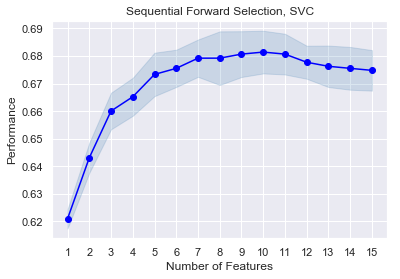

In [807]:
# Get the "best" features after SFS
best_sfs = clf_SVC.best_estimator_["sfs_SVC"]

# Print performance vs number of features
fig = plot_sfs(best_sfs.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection, SVC')
plt.grid()

print("Number of Features: {}".format(len(best_sfs.k_feature_idx_)))
print("Feature indices:    {}".format(best_sfs.k_feature_idx_))

In [808]:
# Define predictors and outcome. Convert into numpy array
X = datasets["Winsorized_Healthy"].iloc[:, 1:]
Y = datasets["Winsorized_Healthy"]["Tumor type"].values

# Transform X using corresponding scaler
X = data_Scalers_SVC["Winsorized_Healthy_scaled"].fit_transform(X)

# Select the "best" features
X = X[:, best_sfs.k_feature_idx_]

# Get the best estimator
best_estimator = clf_SVC.best_estimator_["svc"]


# Cross validate the model with 10 folds on Specificity, Sensitivity (Recall) and Accuracy.
SVC_crossV_score = cross_validate(best_estimator, X, Y, cv=10, 
                              scoring={'spec_macro': make_scorer(specificity_score, average='weighted'),
                                       'rec_macro' : make_scorer(recall_score, average='weighted'),
                                       'acc'       : 'accuracy'}, 
                              n_jobs=3, return_train_score=True, verbose=3)

# Store cv results
cv_scores_SVC[dataset_name] = SVC_crossV_score

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.4s finished


In [809]:
# Create a summary over the Cross Validation scores. 
cv_scores_df_SVC = pd.DataFrame(columns=["Winsorized_Healthy_scaled"], 
                               index=["Specificity", "Sensitivity", "Accuracy"])

for dataset_name in cv_scores_df_SVC.columns:
    specificity = round(np.median(cv_scores_SVC[dataset_name]["test_spec_macro"]), 4)
    sensitivity = round(np.median(cv_scores_SVC[dataset_name]["test_rec_macro"]), 4)
    accuracy = round(np.median(cv_scores_SVC[dataset_name]["test_acc"]), 4)
    cv_scores_df_SVC[dataset_name] = [specificity, sensitivity, accuracy]
    
cv_scores_df_SVC

,Winsorized_Healthy_scaled
Specificity,0.9877
Sensitivity,0.6834
Accuracy,0.6834


Best performing model:
 SVC(C=50, break_ties=False, cache_size=500, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


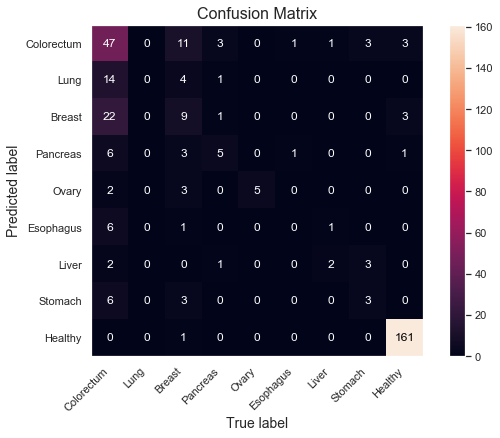

In [810]:
# Print best performing model parameters
best_model = models_SVC["Winsorized_Healthy_scaled"]
print("Best performing model:\n", best_model)

# Split into train and test sets, same as during training
_, testX, _, testY = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Make predictions on above set and plot Confusion Matrix
plot_confusion_matrix(testY, best_model.predict(testX), target_names=[i for i in cancers[:9]], 
                      title = 'Confusion Matrix')

Also SVC perform worse with SFS when 15 features are being evaluated and compared with the original 10 features.  


## Random Forest

About parameter tuning [here](https://scikit-learn.org/stable/modules/ensemble.html#parameters). 

In [25]:
# Store Cross Validated scores, models and scalers here
cv_scores_RF = {}; models_RF = {}; metrics_RF = {}

# Time it
start = time.time()

# Fit, train and cross validate on all seven datasets
for dataset_name in datasets:

    # Define predictors and outcome. Convert into numpy array
    X = datasets[dataset_name].iloc[:, 1:]
    Y = datasets[dataset_name]["Tumor type"].values
    
    # Split into train and test sets. Use 20% for testing
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
    
    # Create Random Forest for classification
    rf = ensemble.RandomForestClassifier()
    
    print(f'   Recursive Feature Elimination cv=5 & Grid Search cv=5 on {dataset_name}')
    
    # Find the best set of features using Sequential Forward Selection
    sfs_RF = SFS(estimator=rf, 
                 k_features=(5, 15),
                 forward=True, 
                 floating=False, 
                 scoring='accuracy',
                 cv=5)
    
    # Create a Pipeline
    pipeline_RF = Pipeline([('sfs_RF', sfs_RF), 
                            ('rf', rf)])

    # Set parameters for Grid Search
    param_grid = {'rf__max_depth': [3, 4, 5],
                  'rf__n_estimators': [300, 400]}
    
    
    # Initiate Cross Validated Grid Search to get the best model
    clf_RF = GridSearchCV(pipeline_RF, 
                          param_grid,
                          verbose=3, 
                          n_jobs=3,
                          cv=5)
    
    clf_RF.fit(trainX, trainY)
    
    # Store the best model
    models_RF[dataset_name] = clf_RF.best_estimator_["rf"]
    
    # Store all metrics from the Grid Search
    metrics_RF[dataset_name] = clf_RF
        
    
print("\nDone!")

# Print total time
end = time.time()
tt = end-start
print("\nTotal time: {0:0.0f} min and {1:0.0f}s. ".format((tt-tt%60)/60, tt%60)) 

   Recursive Feature Elimination cv=5 & Grid Search cv=5 on Winsorized_Healthy
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed: 39.7min finished



Done!

Total time: 42 min and 55s. 


Number of Features: 7
Feature indices:    (0, 2, 3, 4, 8, 9, 13)


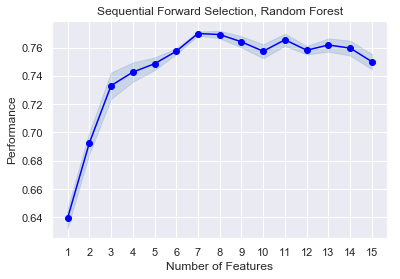

In [55]:
# Get the "best" features after SFS
best_sfs = clf_RF.best_estimator_["sfs_RF"]

# Print performance vs number of features
fig = plot_sfs(best_sfs.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection, Random Forest')
plt.grid()

print("Number of Features: {}".format(len(best_sfs.k_feature_idx_)))
print("Feature indices:    {}".format(best_sfs.k_feature_idx_))

In [51]:
# Define predictors and outcome. Convert into numpy array
X = datasets["Winsorized_Healthy"].iloc[:, 1:]
Y = datasets["Winsorized_Healthy"]["Tumor type"].values

# Select the "best" features
X = X.iloc[:, list(best_sfs.k_feature_idx_)]

# Get the best estimator
best_estimator = clf_RF.best_estimator_["rf"]


# Cross validate the model with 10 folds on Specificity, Sensitivity (Recall) and Accuracy.
RF_crossV_score = cross_validate(best_estimator, X, Y, cv=10, 
                              scoring={'spec_macro': make_scorer(specificity_score, average='weighted'),
                                       'rec_macro' : make_scorer(recall_score, average='weighted'),
                                       'acc'       : 'accuracy'}, 
                              n_jobs=3, return_train_score=True, verbose=3)

# Store cv results
cv_scores_RF[dataset_name] = RF_crossV_score

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    7.7s finished


In [52]:
# Create a summary over the Cross Validation scores. 
cv_scores_df_RF = pd.DataFrame(columns=["Winsorized_Healthy"], 
                               index=["Specificity", "Sensitivity", "Accuracy"])

for dataset_name in cv_scores_df_RF.columns:
    specificity = round(np.median(cv_scores_RF[dataset_name]["test_spec_macro"]), 4)
    sensitivity = round(np.median(cv_scores_RF[dataset_name]["test_rec_macro"]), 4)
    accuracy = round(np.median(cv_scores_RF[dataset_name]["test_acc"]), 4)
    cv_scores_df_RF[dataset_name] = [specificity, sensitivity, accuracy]
    
cv_scores_df_RF

,Winsorized_Healthy
Specificity,1.000
Sensitivity,0.708
Accuracy,0.708


In [53]:
## Save the best models with corresponding scalers and all CV scores
#for filename in ['Winsorized_Healthy']:
#    dump(models_RF[filename], 'RF_SFS_'+filename+'.joblib')
#    dump(data_Scalers_RF[filename+'_scaled'], 'RF_SFS_'+filename+'_scaler'+'.save')
#
#pd.DataFrame(cv_scores_RF).to_csv("RF_SFS_cvScores.csv")
#print("Done!")
#

# Load model and scaler from disk
#model_RF = load('RF_'+filename+'.joblib')
#scaler_RF = load('RF_'+filename+'_scaler'+'.save')

Best performing model:
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


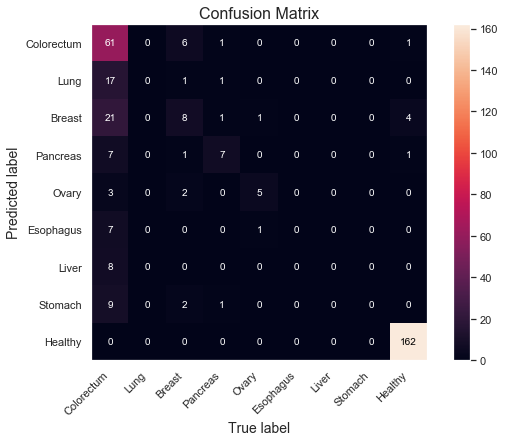

,feature,importance
5,TIMP-1 (pg/ml),0.309261
0,Aneuploidy,0.232631
6,CA19-9 + CEA + HGF + OPN,0.202690
4,Prolactin (pg/ml),0.082403
3,CA19-9 (U/ml),0.074553
2,CA-125 (U/ml),0.058290
1,AFP (pg/ml),0.040172


In [54]:
# Print best performing model parameters
best_model = models_RF["Winsorized_Healthy"]
print("Best performing model:\n", best_model)

# Split into train and test sets, same as during training
_, testX, _, testY = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Make predictions on above set and plot Confusion Matrix
plot_confusion_matrix(testY, best_model.predict(testX), target_names=[i for i in cancers[:9]], 
                      title = 'Confusion Matrix')

# Print feature importance
print_feature_importance(best_model, X, n=len(best_sfs.k_feature_idx_))

Random Forest performs slightly worse with SFS than orignally. 


## Gradient Boosting

In [56]:
# Store Cross Validated scores, models and scalers here
cv_scores_GB = {}; models_GB = {}; metrics_GB = {}

# Time it
start = time.time()

# Fit, train and cross validate on all seven datasets
for dataset_name in datasets:

    # Define predictors and outcome. Convert into numpy array
    X = datasets[dataset_name].iloc[:, 1:]
    Y = datasets[dataset_name]["Tumor type"].values
    
    # Split into train and test sets. Use 20% for testing
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
    
    # Create Gradient Boosting for classification
    gb = ensemble.GradientBoostingClassifier(learning_rate=0.1)
    
    print(f'   Recursive Feature Elimination cv=5 & Grid Search cv=5 on {dataset_name}')
    
    # Find the best set of features using Sequential Forward Selection
    sfs_GB = SFS(estimator=gb, 
                 k_features=(5, 15),
                 forward=True, 
                 floating=False, 
                 scoring='accuracy',
                 cv=5)
    
    # Create a Pipeline
    pipeline_GB = Pipeline([('sfs_GB', sfs_GB), 
                            ('gb', gb)])

    # Set parameters for Grid Search
    param_grid = {'gb__max_depth': [2, 3, 4],
                  'gb__n_estimators': [300, 400]}
    
    
    # Initiate Cross Validated Grid Search to get the best model
    clf_GB = GridSearchCV(pipeline_GB, 
                          param_grid,
                          verbose=3, 
                          n_jobs=3,
                          cv=5)
    
    clf_GB.fit(trainX, trainY)
    
    # Store the best model
    models_GB[dataset_name] = clf_GB.best_estimator_["gb"]
    
    # Store all metrics from the Grid Search
    metrics_GB[dataset_name] = clf_GB
    
    
print("\nDone!")

# Print total time
end = time.time()
tt = end-start
print("\nTotal time: {0:0.0f} min and {1:0.0f}s. ".format((tt-tt%60)/60, tt%60)) 

   Recursive Feature Elimination cv=5 & Grid Search cv=5 on Winsorized_Healthy
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed: 251.5min finished



Done!

Total time: 269 min and 54s. 


Number of Features: 9
Feature indices:    (0, 1, 2, 3, 4, 5, 8, 9, 12)


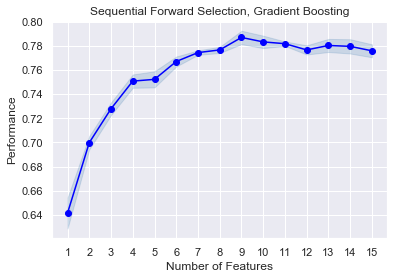

In [57]:
# Get the "best" features after SFS
best_sfs = clf_GB.best_estimator_["sfs_GB"]

# Print performance vs number of features
fig = plot_sfs(best_sfs.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection, Gradient Boosting')
plt.grid()

print("Number of Features: {}".format(len(best_sfs.k_feature_idx_)))
print("Feature indices:    {}".format(best_sfs.k_feature_idx_))

In [58]:
# Define predictors and outcome. Convert into numpy array
X = datasets["Winsorized_Healthy"].iloc[:, 1:]
Y = datasets["Winsorized_Healthy"]["Tumor type"].values

# Select the "best" features
X = X.iloc[:, list(best_sfs.k_feature_idx_)]

# Get the best estimator
best_estimator = clf_GB.best_estimator_["gb"]


# Cross validate the model with 10 folds on Specificity, Sensitivity (Recall) and Accuracy.
GB_crossV_score = cross_validate(best_estimator, X, Y, cv=10, 
                              scoring={'spec_macro': make_scorer(specificity_score, average='weighted'),
                                       'rec_macro' : make_scorer(recall_score, average='weighted'),
                                       'acc'       : 'accuracy'}, 
                              n_jobs=3, return_train_score=True, verbose=3)

# Store cv results
cv_scores_GB[dataset_name] = GB_crossV_score

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  1.2min finished


In [59]:
# Create a summary over the Cross Validation scores. 
cv_scores_df_GB = pd.DataFrame(columns=["Winsorized_Healthy"], 
                               index=["Specificity", "Sensitivity", "Accuracy"])

for dataset_name in cv_scores_df_GB.columns:
    specificity = round(np.median(cv_scores_GB[dataset_name]["test_spec_macro"]), 4)
    sensitivity = round(np.median(cv_scores_GB[dataset_name]["test_rec_macro"]), 4)
    accuracy = round(np.median(cv_scores_GB[dataset_name]["test_acc"]), 4)
    cv_scores_df_GB[dataset_name] = [specificity, sensitivity, accuracy]
    
cv_scores_df_GB

,Winsorized_Healthy
Specificity,1.0000
Sensitivity,0.7278
Accuracy,0.7278


In [1]:
# Save the best models and all CV scores
#for filename in ['Winsorized_Healthy']:
#    dump(models_GB[filename], 'GB_SFS_'+filename+'.joblib')
#
#pd.DataFrame(cv_scores_GB).to_csv("GB_SFS_cvScores.csv")
#print("Done!")

Best performing model:
 GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=400,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


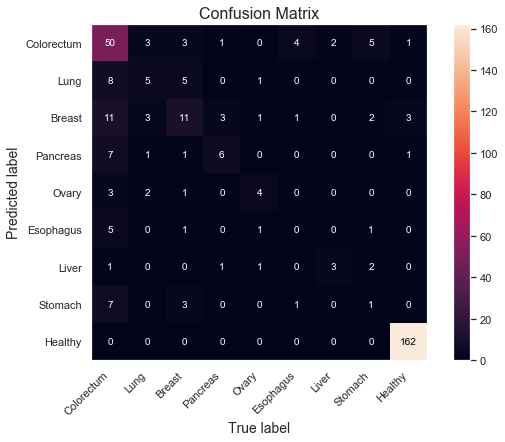

,feature,importance
7,TIMP-1 (pg/ml),0.334149
8,Mutation + CEA + HGF + OPN,0.146287
0,Aneuploidy,0.135723
4,CA19-9 (U/ml),0.082462
6,Prolactin (pg/ml),0.072334
2,AFP (pg/ml),0.067913
3,CA-125 (U/ml),0.062761
1,Mutation,0.055260
5,CEA (pg/ml),0.043110


In [60]:
# Print best performing model parameters
best_model = models_GB["Winsorized_Healthy"]
print("Best performing model:\n", best_model)

# Split into train and test sets, same as during training
_, testX, _, testY = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Make predictions on above set and plot Confusion Matrix
plot_confusion_matrix(testY, best_model.predict(testX), target_names=[i for i in cancers[:9]], 
                      title = 'Confusion Matrix')

# Print feature importance
print_feature_importance(best_model, X, n=len(best_sfs.k_feature_idx_))

Gradient Boosting pushes the results slightly more, to 73% in sensitivity while keeping specificity at 100%. The most important feature, just as for Random Forest, is `TIMP-1 (pg/ml)`. Gradient Boosting gives it slightly more importance though. It is interesting to note that the newly added feature (compared with the previous publication) `Aneuploidy`'s importance is only the third most important for the model, while several of the other fatures play little importance at all. 


## XGBoost



In [61]:
# Store Cross Validated scores, models and scalers here
cv_scores_XGB = {}; models_XGB = {}; metrics_XGB = {}

# Time it
start = time.time()

# Fit, train and cross validate on all seven datasets
for dataset_name in datasets:

    # Define predictors and outcome. Convert into numpy array
    X = datasets[dataset_name].iloc[:, 1:]
    Y = datasets[dataset_name]["Tumor type"].values
    
    # Split into train and test sets. Use 20% for testing
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
    
    # Create XGBoost for Classification
    xgboost = xgb.XGBClassifier(learning_rate=0.1, 
                                booster='gbtree',
                                eval_metric='merror')
    
    print(f'   Recursive Feature Elimination cv=5 & Grid Search cv=5 on {dataset_name}')
    
    # Find the best set of features using Sequential Forward Selection
    sfs_XGB = SFS(estimator=xgboost, 
                  k_features=(5, 15),
                  forward=True, 
                  floating=False, 
                  scoring='accuracy',
                  cv=5)
    
    # Create a Pipeline
    pipeline_XGB = Pipeline([('sfs_XGB', sfs_XGB), 
                            ('xgboost', xgboost)])

    # Set parameters for Grid Search
    param_grid = {'xgboost__max_depth': [2, 3],
                  'xgboost__n_estimators': [300, 400, 500]}
    
    # Initiate Cross Validated Grid Search to get the best model
    clf_XGB = GridSearchCV(pipeline_XGB, 
                          param_grid,
                          verbose=3, 
                          n_jobs=3,
                          cv=5)
    
    clf_XGB.fit(trainX, trainY)
    
    # Store the best model
    models_XGB[dataset_name] = clf_XGB.best_estimator_["xgboost"]
    
    # Store all metrics from the Grid Search
    metrics_XGB[dataset_name] = clf_XGB
    
    
print("\nDone!")

# Print total time
end = time.time()
tt = end-start
print("\nTotal time: {0:0.0f} min and {1:0.0f}s. ".format((tt-tt%60)/60, tt%60)) 

   Recursive Feature Elimination cv=5 & Grid Search cv=5 on Winsorized_Healthy
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed: 58.4min finished



Done!

Total time: 63 min and 22s. 


Number of Features: 13
Feature indices:    (0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13)


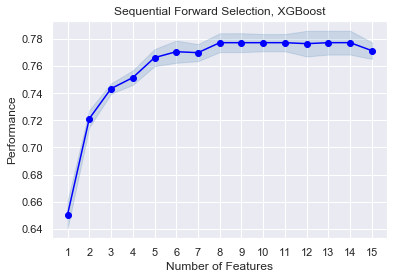

In [62]:
# Get the "best" features after SFS
best_sfs = clf_XGB.best_estimator_["sfs_XGB"]

# Print performance vs number of features
fig = plot_sfs(best_sfs.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection, XGBoost')
plt.grid()

print("Number of Features: {}".format(len(best_sfs.k_feature_idx_)))
print("Feature indices:    {}".format(best_sfs.k_feature_idx_))

In [63]:
# Define predictors and outcome. Convert into numpy array
X = datasets["Winsorized_Healthy"].iloc[:, 1:]
Y = datasets["Winsorized_Healthy"]["Tumor type"].values

# Select the "best" features
X = X.iloc[:, list(best_sfs.k_feature_idx_)]

# Get the best estimator
best_estimator = clf_XGB.best_estimator_["xgboost"]


# Cross validate the model with 10 folds on Specificity, Sensitivity (Recall) and Accuracy.
XGB_crossV_score = cross_validate(best_estimator, X, Y, cv=10, 
                              scoring={'spec_macro': make_scorer(specificity_score, average='weighted'),
                                       'rec_macro' : make_scorer(recall_score, average='weighted'),
                                       'acc'       : 'accuracy'}, 
                              n_jobs=3, return_train_score=True, verbose=3)

# Store cv results
cv_scores_XGB[dataset_name] = XGB_crossV_score

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   22.2s finished


In [64]:
# Create a summary over the Cross Validation scores. 
cv_scores_df_XGB = pd.DataFrame(columns=["Winsorized_Healthy"], 
                               index=["Specificity", "Sensitivity", "Accuracy"])

for dataset_name in cv_scores_df_XGB.columns:
    specificity = round(np.median(cv_scores_XGB[dataset_name]["test_spec_macro"]), 4)
    sensitivity = round(np.median(cv_scores_XGB[dataset_name]["test_rec_macro"]), 4)
    accuracy = round(np.median(cv_scores_XGB[dataset_name]["test_acc"]), 4)
    cv_scores_df_XGB[dataset_name] = [specificity, sensitivity, accuracy]
    
cv_scores_df_XGB

,Winsorized_Healthy
Specificity,1.0000
Sensitivity,0.7404
Accuracy,0.7404


In [65]:
# Save the best models and all CV scores
#for filename in ['Winsorized_Healthy']:
#    dump(models_XGB[filename], 'XGB_SFS_'+filename+'.joblib')
#
#pd.DataFrame(cv_scores_XGB).to_csv("XGB_SFS_cvScores.csv")
#print("Done!")

Best performing model:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='merror',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


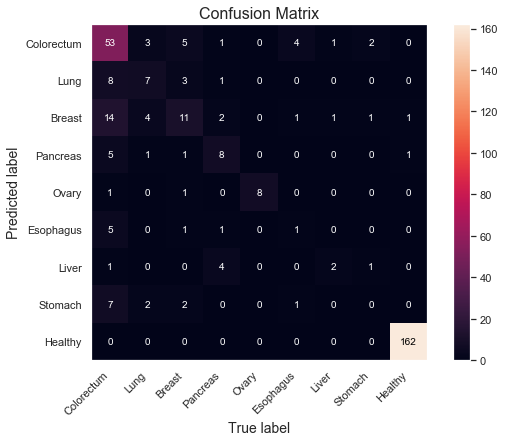

,feature,importance
8,TIMP-1 (pg/ml),0.199476
9,CEA+HGF+OPN,0.122503
0,Aneuploidy,0.109037
4,CA19-9 (U/ml),0.106463
3,CA-125 (U/ml),0.072010
6,HGF (pg/ml),0.065111
11,Mutation + CEA + HGF + OPN,0.062043
2,AFP (pg/ml),0.056696
1,Mutation,0.055020
7,OPN (pg/ml),0.046664


In [67]:
# Print best performing model parameters
best_model = models_XGB["Winsorized_Healthy"]
print("Best performing model:\n", best_model)

# Split into train and test sets, same as during training
_, testX, _, testY = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Make predictions on above set and plot Confusion Matrix
plot_confusion_matrix(testY, best_model.predict(testX.values), target_names=[i for i in cancers[:9]], 
                      title = 'Confusion Matrix')

# Print feature importance
print_feature_importance(best_model, X, n=len(best_sfs.k_feature_idx_))

XGBoost increased the performance slightly more, to 74% sensitivity, while keeping 100% in specificity. Two out of the top three most important features are equal as for Gradient Boosting; `TIM-1 (pg/ml)` and `Aneuploidy`, but with considerable less importance to `TIM-1 (pg/ml)`. 


## LightGBM

In [72]:
# Store Cross Validated scores, models and scalers here
cv_scores_LGBM = {}; models_LGBM = {}; metrics_LGBM = {}

# Time it
start = time.time()

# Fit, train and cross validate on all seven datasets
for dataset_name in datasets:

    # Define predictors and outcome. Convert into numpy array
    X = datasets[dataset_name].iloc[:, 1:]
    Y = datasets[dataset_name]["Tumor type"].values
    
    # Split into train and test sets. Use 20% for testing
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
    
    # Create LightGBM for Classification
    lgbm = lgb.LGBMClassifier(learning_rate=0.1, 
                              objective='multiclass')
    
    print(f'   Recursive Feature Elimination cv=5 & Grid Search cv=5 on {dataset_name}')
    
    # Find the best set of features using Sequential Forward Selection
    sfs_LGBM = SFS(estimator=lgbm, 
                   k_features=(5, 15),
                   forward=True, 
                   floating=False, 
                   scoring='accuracy',
                   cv=5)
    
    # Create a Pipeline
    pipeline_LGBM = Pipeline([('sfs_LGBM', sfs_LGBM), 
                              ('lgbm', lgbm)])

    # Set parameters for Grid Search
    param_grid = {'lgbm__max_depth': [4, 5],
                  'lgbm__n_estimators': [300, 400, 500],
                  'lgbm__subsample': [0.75, 1.0]}
    
    # Initiate Cross Validated Grid Search to get the best model
    clf_LGBM = GridSearchCV(pipeline_LGBM, 
                            param_grid,
                            verbose=3, 
                            n_jobs=3,
                            cv=5)
    clf_LGBM.fit(trainX, trainY)
    
    # Store the best model
    models_LGBM[dataset_name] = clf_LGBM.best_estimator_["lgbm"]
    
    # Store all metrics from the Grid Search
    metrics_LGBM[dataset_name] = clf_LGBM
    
    
print("\nDone!")

# Print total time
end = time.time()
tt = end-start
print("\nTotal time: {0:0.0f} min and {1:0.0f}s. ".format((tt-tt%60)/60, tt%60)) 

   Recursive Feature Elimination cv=5 & Grid Search cv=5 on Winsorized_Healthy
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 104.7min
[Parallel(n_jobs=3)]: Done  60 out of  60 | elapsed: 231.7min finished



Done!

Total time: 238 min and 26s. 


Number of Features: 14
Feature indices:    (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14)


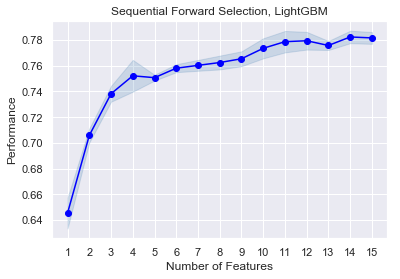

In [75]:
# Get the "best" features after SFS
best_sfs = clf_LGBM.best_estimator_["sfs_LGBM"]

# Print performance vs number of features
fig = plot_sfs(best_sfs.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection, LightGBM')
plt.grid()

print("Number of Features: {}".format(len(best_sfs.k_feature_idx_)))
print("Feature indices:    {}".format(best_sfs.k_feature_idx_))

In [76]:
# Define predictors and outcome. Convert into numpy array
X = datasets["Winsorized_Healthy"].iloc[:, 1:]
Y = datasets["Winsorized_Healthy"]["Tumor type"].values

# Select the "best" features
X = X.iloc[:, list(best_sfs.k_feature_idx_)]

# Get the best estimator
best_estimator = clf_LGBM.best_estimator_["lgbm"]


# Cross validate the model with 10 folds on Specificity, Sensitivity (Recall) and Accuracy.
LGBM_crossV_score = cross_validate(best_estimator, X, Y, cv=10, 
                              scoring={'spec_macro': make_scorer(specificity_score, average='weighted'),
                                       'rec_macro' : make_scorer(recall_score, average='weighted'),
                                       'acc'       : 'accuracy'}, 
                              n_jobs=3, return_train_score=True, verbose=3)

# Store cv results
cv_scores_LGBM[dataset_name] = LGBM_crossV_score

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  1.0min finished


In [77]:
# Create a summary over the Cross Validation scores. 
cv_scores_df_LGBM = pd.DataFrame(columns=["Winsorized_Healthy"], 
                               index=["Specificity", "Sensitivity", "Accuracy"])

for dataset_name in cv_scores_df_LGBM.columns:
    specificity = round(np.median(cv_scores_LGBM[dataset_name]["test_spec_macro"]), 4)
    sensitivity = round(np.median(cv_scores_LGBM[dataset_name]["test_rec_macro"]), 4)
    accuracy = round(np.median(cv_scores_LGBM[dataset_name]["test_acc"]), 4)
    cv_scores_df_LGBM[dataset_name] = [specificity, sensitivity, accuracy]
    
cv_scores_df_LGBM

,Winsorized_Healthy
Specificity,0.9939
Sensitivity,0.7286
Accuracy,0.7286


In [78]:
# Save the best models and all CV scores
#for filename in ['Winsorized_Healthy']:
#    dump(models_LGBM[filename], 'LGBM_SFS_'+filename+'.joblib')
#
#pd.DataFrame(cv_scores_LGBM).to_csv("LGBM_SFS_cvScores.csv")
#print("Done!")

Best performing model:
 LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=5,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=500, n_jobs=-1, num_leaves=31,
               objective='multiclass', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=0.75,
               subsample_for_bin=200000, subsample_freq=0)


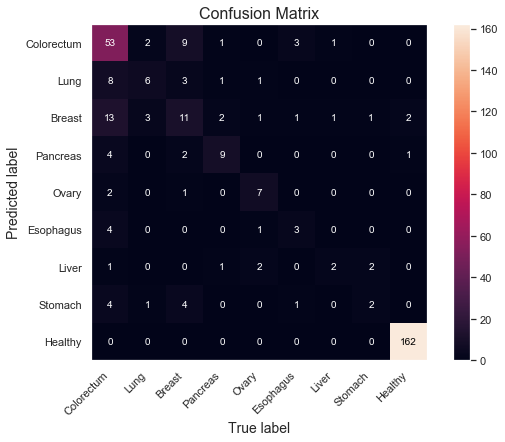

,feature,importance
2,AFP (pg/ml),5824
9,TIMP-1 (pg/ml),5667
0,Aneuploidy,5622
1,Mutation,5287
3,CA-125 (U/ml),5166
8,Prolactin (pg/ml),5166
6,HGF (pg/ml),5146
5,CEA (pg/ml),5047
4,CA19-9 (U/ml),4166
10,Mutation + CA19-9,3609


In [79]:
# Print best performing model parameters
best_model = models_LGBM["Winsorized_Healthy"]
print("Best performing model:\n", best_model)

# Split into train and test sets, same as during training
_, testX, _, testY = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Make predictions on above set and plot Confusion Matrix
plot_confusion_matrix(testY, best_model.predict(testX), target_names=[i for i in cancers[:9]], 
                      title = 'Confusion Matrix')

# Print feature importance
print_feature_importance(best_model, X, n=len(best_sfs.k_feature_idx_))

LightGBM performs very well as well with a sensitivity of 73% and specificity >99%.



## CatBoost

In [73]:
# Store Cross Validated scores, models and scalers here
cv_scores_CB = {}; models_CB = {}; metrics_CB = {}

# Time it
start = time.time()

# Fit, train and cross validate on all seven datasets
for dataset_name in datasets:

    # Define predictors and outcome. Convert into numpy array
    X = datasets[dataset_name].iloc[:, 1:]
    Y = datasets[dataset_name]["Tumor type"].values
    
    # Split into train and test sets. Use 20% for testing
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
    
    # Create CatBoost for Classification
    cb = CatBoostClassifier(learning_rate=0.1,
                            eval_metric="MultiClass",
                            bootstrap_type="Bernoulli",
                            colsample_bylevel=0.75,
                            verbose=False)
    
    print(f'   Recursive Feature Elimination cv=5 & Grid Search cv=5 on {dataset_name}')
    
    # Find the best set of features using Sequential Forward Selection
    sfs_CB = SFS(estimator=lgbm, 
                   k_features=(5, 15),
                   forward=True, 
                   floating=False, 
                   scoring='accuracy',
                   cv=5)
    
    # Create a Pipeline
    pipeline_CB = Pipeline([('sfs_CB', sfs_CB), 
                            ('cb', cb)])

    # Set parameters for Grid Search
    param_grid = {'cb__max_depth': [3, 4],
                  'cb__n_estimators': [400, 500]}
    
    # Initiate Cross Validated Grid Search to get the best model
    clf_CB = GridSearchCV(pipeline_CB, 
                          param_grid,
                          verbose=3, 
                          n_jobs=3,
                          cv=5)
    clf_CB.fit(trainX, trainY)
    
    # Store the best model
    models_CB[dataset_name] = clf_CB.best_estimator_["cb"]
    
    # Store all metrics from the Grid Search
    metrics_CB[dataset_name] = clf_CB
    
    
print("\nDone!")

# Print total time
end = time.time()
tt = end-start
print("\nTotal time: {0:0.0f} min and {1:0.0f}s. ".format((tt-tt%60)/60, tt%60)) 

   Recursive Feature Elimination cv=5 & Grid Search cv=5 on Winsorized_Healthy
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  20 out of  20 | elapsed: 77.3min finished



Done!

Total time: 83 min and 58s. 


Number of Features: 14
Feature indices:    (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14)


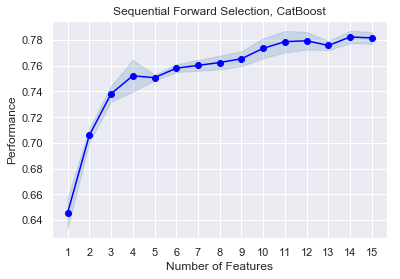

In [80]:
# Get the "best" features after SFS
best_sfs = clf_CB.best_estimator_["sfs_CB"]

# Print performance vs number of features
fig = plot_sfs(best_sfs.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection, CatBoost')
plt.grid()

print("Number of Features: {}".format(len(best_sfs.k_feature_idx_)))
print("Feature indices:    {}".format(best_sfs.k_feature_idx_))

In [82]:
# Define predictors and outcome. Convert into numpy array
X = datasets["Winsorized_Healthy"].iloc[:, 1:]
Y = datasets["Winsorized_Healthy"]["Tumor type"].values

# Select the "best" features
X = X.iloc[:, list(best_sfs.k_feature_idx_)]

# Get the best estimator
best_estimator = clf_CB.best_estimator_["cb"]


# Cross validate the model with 10 folds on Specificity, Sensitivity (Recall) and Accuracy.
CB_crossV_score = cross_validate(best_estimator, X, Y, cv=10, 
                              scoring={'spec_macro': make_scorer(specificity_score, average='weighted'),
                                       'rec_macro' : make_scorer(recall_score, average='weighted'),
                                       'acc'       : 'accuracy'}, 
                              n_jobs=3, return_train_score=True, verbose=3)

# Store cv results
cv_scores_CB[dataset_name] = CB_crossV_score

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   19.9s finished


In [83]:
# Create a summary over the Cross Validation scores. 
cv_scores_df_CB = pd.DataFrame(columns=["Winsorized_Healthy"], 
                               index=["Specificity", "Sensitivity", "Accuracy"])

for dataset_name in cv_scores_df_CB.columns:
    specificity = round(np.median(cv_scores_CB[dataset_name]["test_spec_macro"]), 4)
    sensitivity = round(np.median(cv_scores_CB[dataset_name]["test_rec_macro"]), 4)
    accuracy = round(np.median(cv_scores_CB[dataset_name]["test_acc"]), 4)
    cv_scores_df_CB[dataset_name] = [specificity, sensitivity, accuracy]
    
cv_scores_df_CB

,Winsorized_Healthy
Specificity,1.0000
Sensitivity,0.7396
Accuracy,0.7396


In [84]:
# Save the best models and all CV scores
#for filename in ['Winsorized_Healthy']:
#    dump(models_CB[filename], 'CB_SFS_'+filename+'.joblib')
#
#pd.DataFrame(cv_scores_CB).to_csv("CB_SFS_cvScores.csv")
#print("Done!")

Best performing model:
 {'learning_rate': 0.1, 'verbose': False, 'eval_metric': 'MultiClass', 'bootstrap_type': 'Bernoulli', 'max_depth': 3, 'n_estimators': 500, 'colsample_bylevel': 0.75}


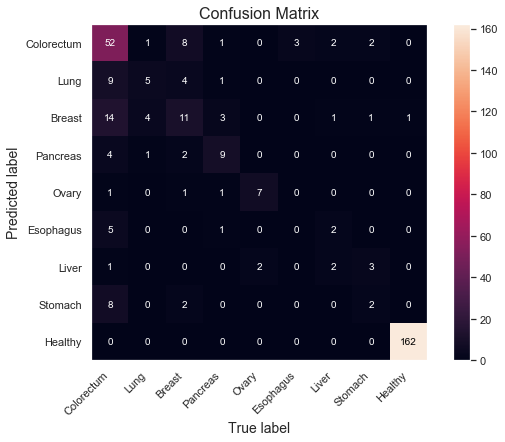

,feature,importance
9,TIMP-1 (pg/ml),16.654806
0,Aneuploidy,14.720199
3,CA-125 (U/ml),8.984559
4,CA19-9 (U/ml),8.585805
8,Prolactin (pg/ml),8.136101
1,Mutation,7.894444
6,HGF (pg/ml),6.763696
2,AFP (pg/ml),6.615989
13,Combination assay,4.837573
5,CEA (pg/ml),4.016111


In [85]:
# Print best performing model parameters
best_model = models_CB["Winsorized_Healthy"]
print("Best performing model:\n", best_model.get_params())

# Split into train and test sets, same as during training
_, testX, _, testY = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Make predictions on above set and plot Confusion Matrix
plot_confusion_matrix(testY, best_model.predict(testX), target_names=[i for i in cancers[:9]], 
                      title = 'Confusion Matrix')

# Print feature importance
print_feature_importance(best_model, X, n=len(best_sfs.k_feature_idx_))

CatBoost performs in par with XGBoost with 74% sensitivity and a specificity at 100%.



## Regularized Greedy Forest (RGF)

In [90]:
# Store Cross Validated scores, models and scalers here
cv_scores_RGF = {}; models_RGF = {}; metrics_RGF = {}

# Time it
start = time.time()

# Fit, train and cross validate on all seven datasets
for dataset_name in datasets:

    # Define predictors and outcome. Convert into numpy array
    X = datasets[dataset_name].iloc[:, 1:]
    Y = datasets[dataset_name]["Tumor type"].values
    
    # Split into train and test sets. Use 20% for testing
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
    
    # Create RGF for Classification
    rgf = RGFClassifier(learning_rate=0.1,
                        normalize=False,
                        algorithm="RGF_Sib",
                        max_leaf=400)
    
    print(f'   Recursive Feature Elimination cv=5 & Grid Search cv=5 on {dataset_name}')
    
    # Find the best set of features using Sequential Forward Selection
    sfs_RGF = SFS(estimator=rgf, 
                  k_features=(5, 15),
                  forward=True, 
                  floating=False, 
                  scoring='accuracy',
                  verbose=3,
                  cv=5)
    
    # Create a Pipeline
    pipeline_RGF = Pipeline([('sfs_RGF', sfs_RGF), 
                            ('rgf', rgf)])

    # Set parameters for Grid Search
    param_grid = {'rgf__reg_depth': [1, 2]}
    
    # Initiate Cross Validated Grid Search to get the best model
    clf_RGF = GridSearchCV(pipeline_RGF, 
                           param_grid,
                           verbose=3, 
                           n_jobs=3,
                           cv=5)
    clf_RGF.fit(trainX, trainY)
    
    # Store the best model
    models_RGF[dataset_name] = clf_RGF.best_estimator_["rgf"]
    
    # Store all metrics from the Grid Search
    metrics_RGF[dataset_name] = clf_RGF
    
    
print("\nDone!")

# Print total time
end = time.time()
tt = end-start
print("\nTotal time: {0:0.0f} min and {1:0.0f}s. ".format((tt-tt%60)/60, tt%60)) 

   Recursive Feature Elimination cv=5 & Grid Search cv=5 on Winsorized_Healthy
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed: 201.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 17.5min finished

[2020-03-16 13:29:18] Features: 1/15 -- score: 0.6541187323637943[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed: 17.7min finished

[2020-03-16 13:47:02] Features: 2/15 -- score: 0.7190362491860214[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)


Done!

Total time: 352 min and 7s. 


Number of Features: 10
Feature indices:    (0, 1, 2, 3, 4, 5, 6, 7, 9, 10)


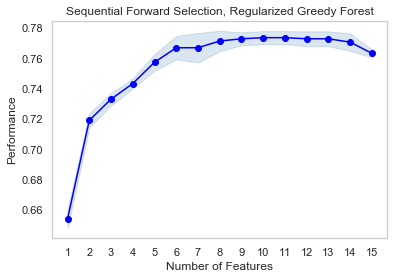

In [91]:
# Get the "best" features after SFS
best_sfs = clf_RGF.best_estimator_["sfs_RGF"]

# Print performance vs number of features
fig = plot_sfs(best_sfs.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection, Regularized Greedy Forest')
plt.grid()

print("Number of Features: {}".format(len(best_sfs.k_feature_idx_)))
print("Feature indices:    {}".format(best_sfs.k_feature_idx_))

In [92]:
# Define predictors and outcome. Convert into numpy array
X = datasets["Winsorized_Healthy"].iloc[:, 1:]
Y = datasets["Winsorized_Healthy"]["Tumor type"].values

# Select the "best" features
X = X.iloc[:, list(best_sfs.k_feature_idx_)]

# Get the best estimator
best_estimator = clf_RGF.best_estimator_["rgf"]


# Cross validate the model with 10 folds on Specificity, Sensitivity (Recall) and Accuracy.
RGF_crossV_score = cross_validate(best_estimator, X, Y, cv=10, 
                              scoring={'spec_macro': make_scorer(specificity_score, average='weighted'),
                                       'rec_macro' : make_scorer(recall_score, average='weighted'),
                                       'acc'       : 'accuracy'}, 
                              n_jobs=3, return_train_score=True, verbose=3)

# Store cv results
cv_scores_RGF[dataset_name] = RGF_crossV_score

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  1.8min finished


In [93]:
# Create a summary over the Cross Validation scores. 
cv_scores_df_RGF = pd.DataFrame(columns=["Winsorized_Healthy"], 
                               index=["Specificity", "Sensitivity", "Accuracy"])

for dataset_name in cv_scores_df_RGF.columns:
    specificity = round(np.median(cv_scores_RGF[dataset_name]["test_spec_macro"]), 4)
    sensitivity = round(np.median(cv_scores_RGF[dataset_name]["test_rec_macro"]), 4)
    accuracy = round(np.median(cv_scores_RGF[dataset_name]["test_acc"]), 4)
    cv_scores_df_RGF[dataset_name] = [specificity, sensitivity, accuracy]
    
cv_scores_df_RGF

,Winsorized_Healthy
Specificity,1.0000
Sensitivity,0.7257
Accuracy,0.7257


In [94]:
# Save the best models and all CV scores
#for filename in ['Winsorized_Healthy']:
#    dump(models_RGF[filename], 'RGF_SFS_'+filename+'.joblib')
#
#pd.DataFrame(cv_scores_RGF).to_csv("RGF_SFS_cvScores.csv")
#print("Done!")

Best performing model:
 RGFClassifier(algorithm='RGF_Sib', calc_prob='sigmoid', init_model=None, l2=0.1,
              learning_rate=0.1, loss='Log', max_leaf=400,
              memory_policy='generous', min_samples_leaf=10, n_iter=None,
              n_jobs=-1, n_tree_search=1, normalize=False, opt_interval=100,
              reg_depth=1, sl2=None, test_interval=100, verbose=0)


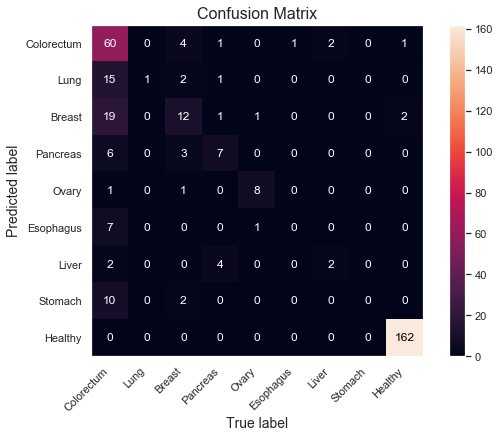

,feature,importance
6,HGF (pg/ml),0.254460
8,TIMP-1 (pg/ml),0.160263
4,CA19-9 (U/ml),0.134680
3,CA-125 (U/ml),0.119759
2,AFP (pg/ml),0.114410
0,Aneuploidy,0.109513
9,CEA+HGF+OPN,0.040260
7,OPN (pg/ml),0.032173
1,Mutation,0.022902
5,CEA (pg/ml),0.011581


In [95]:
# Print best performing model parameters
best_model = models_RGF["Winsorized_Healthy"]
print("Best performing model:\n", best_model)

# Split into train and test sets, same as during training
_, testX, _, testY = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Make predictions on above set and plot Confusion Matrix
plot_confusion_matrix(testY, best_model.predict(testX), target_names=[i for i in cancers[:9]], 
                      title = 'Confusion Matrix')

# Print feature importance
print_feature_importance(best_model, X, n=len(best_sfs.k_feature_idx_))

RGF is extremely slow to train compared with the previous alternatives and is slightly below in terms of performance. Sensitivity is at 72,57% and specificity at 100%.



## Conclusions


Many different algorithms and models have been tested out. Although limited model parameter tuning was done there are some approaches that are more promising than others. XGBoost and CatBoost were all fast to train while achieving the best performance at around 74% sensitivity and 100% specificity. 


LightGBM, RGF and Gradient Boosting took all considerable more time to train while not achieving the same results. It shall be noted that the installation of LightGBM didn't allow the use of a faster implementation. When this at a later stage was achieved the training time was in par with that of XGBoost and Catboost's. Neverheless, the performance was still the same as reported in this experiment. 


Further work on this dataset should thus preferably continue with XGBoost and CatBoost. 